# LANGUAGE COMPETENCE PART 4: Modelling

## Executive Summary

### Problem Statement

Applications for degree courses linked to European languages have fallen by almost a quarter in the past five years, and applications to other language courses have dropped by almost a fifth (source, Press Association analysis).

Would it make a difference if we could predict competence in a foreign language?

### Target Audience

- Schools/boards of education who need justification for funding in targeted areas
- Students who need justification of the factors leading to success in order to continue studying languages

### Project Goal

A model that can predict the achievement of competence in a foreign language on the basis of variable factors.

### Approach

The high level tasks carried out were as follows:

Exploratory Data Analysis (EDA)
- Select data set
- Set Target
- Data analysis to understand distribution of data and correlation with the Target
- Selection of features with strongest correlation with Target
- (Removal of ones with strong co-correlations)

Modelling
- Establish baseline accuracy (0.68)
- Select classifier models (~9)
- Train models against 70% of the data
- Tune models to identify best hyperparameters for optimal model performance
- Test models against remaining 30% of the data
- Identify best performing models, score and visualise outputs (and present to class!)

### Metrics

As this is a classification problem, I relied on the following metrics to evaluate my models:
- Accuracy
- Recall
- Precision
- ROC curve

In terms of my original proposal, I had initially thought to prioritise recall over precision because it was about wanting to encourage people to continue studying and using the idea of their potential to do that. In the context of how I am re-thinking the purpose of the model after seeing the results, I would probably prioritise precision over recall if I were trying to identify people whose habits could be reviewed to enable them to realise higher potential (ie, move from low to high performance class).

### Findings

The best performing model was Random Forest which achieved the following scores against the full dataset:

- Precision: 0.81
- Recall: 0.82
- Accuracy: 0.82
- Baseline Accuracy: 0.68

The best predictors turned out to be:

- Perceived usefulness (job/entertainment/IT)
- Difficulty (inversely)
- Frequency of media consumption (websites/films/TV/music)
- Perceived competence (ability to understand TV & Radio/hold a conversation/write letters, etc.)
- Parents’ language ability
- Enjoyment of language
- Socio-economic status


### Risks/Limitations

l would struggle to recommend this model for the original purpose for the following reasons:
- 49% of the dataset relates to English which could be skewing the feature importance (ie. media)
- Better at predicting low performance than high performance
- Correlation does not necessarily mean causation (does achievement make it enjoyable or vice versa?)

On this basis, further investigation would be required in order for the model to be suitable.

### Next Steps

Expand modelling as follows with a view to deciding whether the model can be used for a different purpose: 

- address high/low performance imbalance in dataset to improve accuracy for high performance
- target language balance in dataset to ensure model is relevant in UK
- apply models to discipline-specific Targets (listening / reading / writing)
- multi-class modelling

I will also review the initial goal of the project to ensure the focus for next steps is appropriate.

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, roc_curve, auc
from sklearn.externals.six import StringIO
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm, linear_model, datasets
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from scipy import stats
import statsmodels.formula.api as sm
from IPython.display import Image  
import pydotplus
import time

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [5]:
# import data
lang = pd.read_csv("/Users/lizspiking/DataScience/language-competence/lang_0506.csv")

## Correlation Matrix

In [6]:
# correlation matrix
lang_corr = lang.corr()

In [7]:
# sort correlation matrix by 'Target_All' column
sorted_corr = lang_corr.sort_values('Target_All', ascending=False)

In [16]:
# select positively correlated features with correlation of 0.2 and above
# and negatively correlated features with correlation of -0.2 and below
features = list(sorted_corr.index[:60])+list(sorted_corr.index[352:])

My gridsearching has been taking a very long time so to speed things up in the short term, I will run my initial models against a subset of the data to identify which models work the best and then I will gridsearch on the couple of models that perform the best on the whole training data set.

In [21]:
# create df of highly correlated features for heatmap
correlated_features = lang.loc[:,features]

In [23]:
# create correlation matrix
high_corr = correlated_features.corr()

In [41]:
# heatmap function to compare correlations
def heatmap_func(data):
    fig,ax = plt.subplots(figsize=(16,16))
    sns.set(font_scale=1.)

    mask = np.zeros_like(data, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    ax = sns.heatmap(data, ax=ax, cmap='coolwarm', center=0, annot=False, mask=mask);

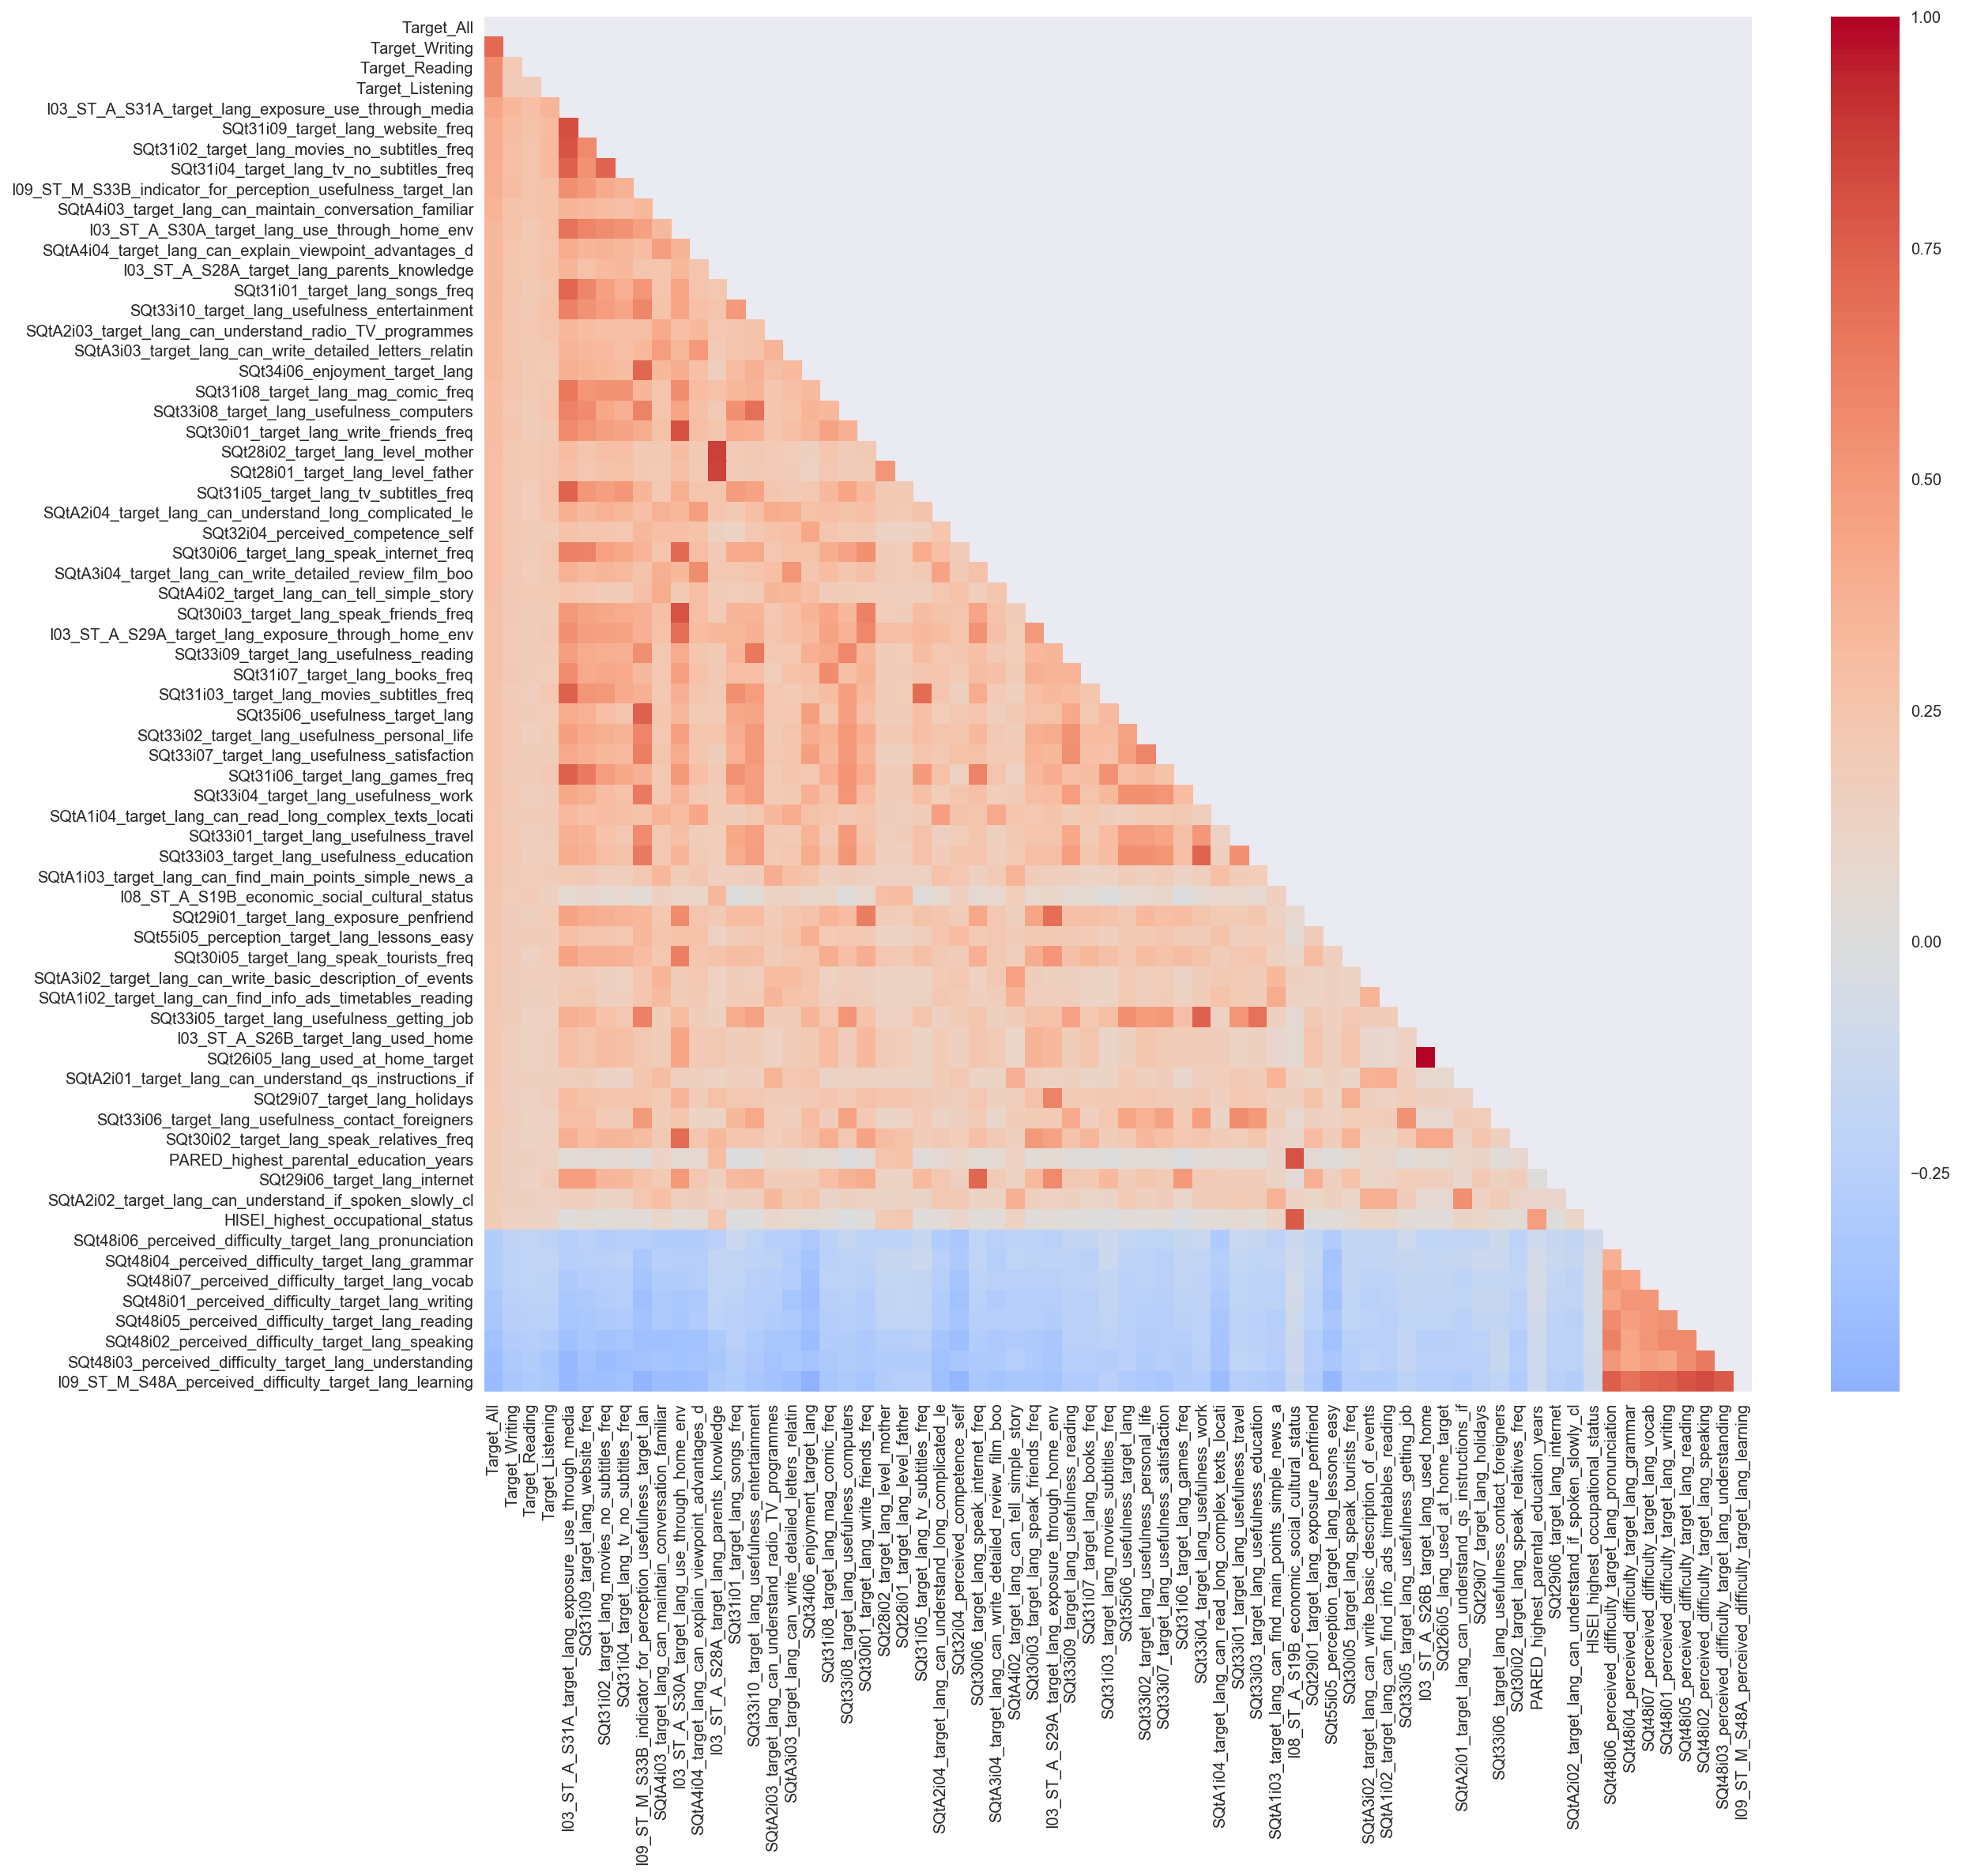

In [42]:
# plot correlation heatmap
heatmap_func(high_corr)

In [32]:
# list of the features which are strongly co-correlated with other predictors
correlated_features = ['I03_ST_A_S31A_target_lang_exposure_use_through_media',\
                       'I03_ST_A_S30A_target_lang_use_through_home_env',\
                       'I03_ST_A_S28A_target_lang_parents_knowledge',\
                       'SQt33i04_target_lang_usefulness_work',\
                       'SQt33i03_target_lang_usefulness_education',\
                       'PARED_highest_parental_education_years']

Looking at the correlation between features within this heatmap, I have decided to remove correlated_features from my predictor matrix as they are very strongly correlated with other features.

In [33]:
# remove co-correlated features from list
final_features = [col for col in features if col not in correlated_features]

In [34]:
# sample 10000 rows from df to speed up gridsearching
lang_subset = lang.sample(n=10000, replace=False, random_state=7, axis=None)

In [35]:
# extract overall target and subset target
y_full = lang.pop('Target_All')
y = lang_subset.pop('Target_All')

In [36]:
# extract other target columns before dummifying
targets_full = lang.loc[:,['Target_Listening','Target_Reading','Target_Writing']].copy()
targets_subset = lang_subset.loc[:,['Target_Listening','Target_Reading','Target_Writing']].copy()

In [37]:
# drop targets from df
lang.drop(targets_full, axis=1, inplace=True)
lang_subset.drop(targets_subset, axis=1, inplace=True)

In [38]:
# set predictor matrices
X_full = lang.loc[:,final_features]
X = lang_subset.loc[:,final_features]

/Users/lizspiking/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
htt

In [43]:
# drop target variable and the discipline-specific targets which I used to create the overall target 
X.drop(['Target_All','Target_Writing',\
        'Target_Reading','Target_Listening'],axis=1, inplace=True)
X_full.drop(['Target_All','Target_Writing',\
             'Target_Reading','Target_Listening'], axis=1, inplace=True)

In [44]:
X.shape

(10000, 58)

## Dummify categorical variables

Am leaving this code here for when I want to add in more features that might need dummifying.

In [45]:
# check that I do want to dummify all object columns
#for_dummies = lang.select_dtypes(include=['object']).columns

In [46]:
# create dummies
#lang_dummies = pd.get_dummies(lang, prefix_sep='_', drop_first=True)
#lang.drop(for_dummies, axis=1, inplace=True)
#lang = pd.concat([lang, lang_dummies], axis=1)

In [47]:
# for clarity, rename overall predictor matrix to X
#X_all = lang

## Baseline Accuracy

In [48]:
# calculate baseline accuracy for each 
baseline = (y.value_counts().max())/y.count()
print(f'Overall baseline accuracy:\t{baseline.round(4)}')

Overall baseline accuracy:	0.6824


## Create train/test splits and scale data

For this first pass of the project I will look at predicting a single result ('Target_All') which encompasses each of the three disciplines tested ('Target_Listening', 'Target_Reading', 'Target_Writing'). As a follow up after my initial submission, one of the follow up actions will be to use my models to try to predict each of these specific sets of results.

In [49]:
y.shape

(10000,)

In [50]:
# create train/test split on sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,\
                                                    shuffle=True,\
                                                    stratify=y,\
                                                    random_state=7)

In [51]:
# instantiate StandardScaler and apply to predictors
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [52]:
# create train/test split on full dataset for gridsearching later
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_full, y_full,\
                                                                    test_size=0.3,\
                                                                    shuffle=True,\
                                                                    random_state=7)

In [53]:
# instantiate StandardScaler and apply to predictors
ss = StandardScaler()
X_all_train_ss = ss.fit_transform(X_all_train)
X_all_test_ss = ss.transform(X_all_test)

## PCA

I set this up but ran out of time to use it so I will leave it in and run some models on it in a subsequent phase of the project.

In [55]:
# fit PCA on the predictors
pca = PCA(n_components=58, random_state=7)
pca.fit(X_train_ss)

PCA(copy=True, iterated_power='auto', n_components=58, random_state=7,
  svd_solver='auto', tol=0.0, whiten=False)

In [56]:
# save components
lang_components = pca.components_

In [57]:
# check eigenvalues
print('Eigenvalues:')
pca.explained_variance_.round(4)

Eigenvalues:


array([1.63133e+01, 4.18870e+00, 3.05570e+00, 2.29230e+00, 2.15070e+00,
       1.81010e+00, 1.56870e+00, 1.39200e+00, 1.20190e+00, 1.13290e+00,
       9.89100e-01, 8.91300e-01, 8.61100e-01, 8.43800e-01, 8.00100e-01,
       7.27300e-01, 7.17200e-01, 6.89700e-01, 6.78900e-01, 6.52900e-01,
       6.45900e-01, 6.27200e-01, 6.03200e-01, 5.79400e-01, 5.72000e-01,
       5.56400e-01, 5.44600e-01, 5.38100e-01, 5.32100e-01, 5.10900e-01,
       5.04900e-01, 4.95500e-01, 4.81700e-01, 4.81300e-01, 4.64400e-01,
       4.57100e-01, 4.46700e-01, 4.46100e-01, 4.39100e-01, 4.23000e-01,
       4.08100e-01, 3.94800e-01, 3.75900e-01, 3.66800e-01, 3.48800e-01,
       3.40400e-01, 3.25300e-01, 3.12500e-01, 3.02400e-01, 2.85900e-01,
       2.83200e-01, 2.40400e-01, 2.26000e-01, 2.14400e-01, 1.35400e-01,
       1.32000e-01, 8.40000e-03, 0.00000e+00])

In [58]:
# review components
print('-------------------------------------\n')

for i, pc in enumerate(['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20']):
    print(pc, 'weighting vector:\n', lang_components[i])
    print('-------------------------------------\n')

-------------------------------------

PC1 weighting vector:
 [ 0.17610917  0.16932319  0.15921706  0.18123022  0.13446415  0.13615623
  0.14705504  0.16112214  0.12424321  0.13246022  0.15276336  0.14707909
  0.16014312  0.15475936  0.09845072  0.09427119  0.13104255  0.1271422
  0.11591696  0.146971    0.12392878  0.10660886  0.14827372  0.15986551
  0.14463519  0.12867347  0.13063422  0.13648936  0.149132    0.14501257
  0.14025195  0.12085037  0.12739671  0.09829532  0.04886957  0.12975756
  0.10950594  0.12415041  0.09496275  0.09359578  0.12450886  0.09983055
  0.09983055  0.09019026  0.09884957  0.11020211  0.12397141  0.11736438
  0.08810703  0.03017177 -0.1221868  -0.11419997 -0.12852818 -0.13766303
 -0.14192972 -0.15671827 -0.15595939 -0.17989547]
-------------------------------------

PC2 weighting vector:
 [ 0.13366808  0.09442928  0.07525251  0.09209451 -0.13160732 -0.09575655
  0.17468857  0.16437355 -0.11242776 -0.11212413 -0.04203569  0.07174686
  0.18931805  0.10881266

In [59]:
lang_exp_var_eigenvals = pca.explained_variance_
lang_exp_var_pct = pca.explained_variance_ratio_

print('Eigenvalues:\n', lang_exp_var_eigenvals, '\n')
print('Explained Variance pct:\n', lang_exp_var_pct)

Eigenvalues:
 [1.63132518e+01 4.18873457e+00 3.05568772e+00 2.29227353e+00
 2.15071706e+00 1.81007744e+00 1.56873594e+00 1.39204224e+00
 1.20188200e+00 1.13294467e+00 9.89135736e-01 8.91327834e-01
 8.61140376e-01 8.43797880e-01 8.00141059e-01 7.27341659e-01
 7.17201195e-01 6.89679224e-01 6.78945082e-01 6.52895695e-01
 6.45929277e-01 6.27221592e-01 6.03227258e-01 5.79408962e-01
 5.72039214e-01 5.56372158e-01 5.44632303e-01 5.38071782e-01
 5.32077481e-01 5.10931989e-01 5.04888131e-01 4.95503328e-01
 4.81716003e-01 4.81261994e-01 4.64433274e-01 4.57067221e-01
 4.46717058e-01 4.46095132e-01 4.39066783e-01 4.23006783e-01
 4.08120007e-01 3.94829084e-01 3.75916580e-01 3.66818779e-01
 3.48836187e-01 3.40396229e-01 3.25306210e-01 3.12456430e-01
 3.02360383e-01 2.85893577e-01 2.83204473e-01 2.40367471e-01
 2.26028833e-01 2.14392783e-01 1.35351431e-01 1.31995411e-01
 8.39258831e-03 1.42378669e-31] 

Explained Variance pct:
 [2.81222782e-01 7.22092446e-02 5.26767446e-02 3.95163113e-02
 3.70760313e

In [60]:
# transform data into new component variable matrix
lang_to_pcs  = pca.transform(X_train_ss)

In [61]:
lang_to_pcs.shape

(7000, 58)

In [63]:
# This transforms our original 58-dimensional data to 3-dimensional data
# The first row is the first student's transformed data.

print(lang_to_pcs[:,:3])

[[-5.11168533 -3.49416587  2.41541732]
 [-1.69372083 -2.38942157 -0.13759139]
 [-2.61246464 -2.03300449 -0.31680803]
 ...
 [ 1.62016789 -1.3330376  -2.70497511]
 [ 0.05398487  0.30066676 -1.15285897]
 [-2.72506939 -0.20466106 -3.09057542]]


In [64]:
# keep in mind that each column in the transformed data is no longer correlated
print(np.corrcoef(lang_to_pcs.T))

[[ 1.00000000e+00 -6.86693729e-15 -7.42389090e-16 ... -3.08006357e-15
   7.06441686e-15  2.41751608e-02]
 [-6.86693729e-15  1.00000000e+00 -8.45618683e-16 ... -1.31036261e-15
   1.63757225e-15  3.44073329e-02]
 [-7.42389090e-16 -8.45618683e-16  1.00000000e+00 ... -1.62330542e-15
  -5.98384903e-16  2.36780167e-01]
 ...
 [-3.08006357e-15 -1.31036261e-15 -1.62330542e-15 ...  1.00000000e+00
   1.40952120e-15  6.87086249e-03]
 [ 7.06441686e-15  1.63757225e-15 -5.98384903e-16 ...  1.40952120e-15
   1.00000000e+00 -1.73969683e-03]
 [ 2.41751608e-02  3.44073329e-02  2.36780167e-01 ...  6.87086249e-03
  -1.73969683e-03  1.00000000e+00]]


In [65]:
# check correlations have been removed
np.allclose(np.corrcoef(lang_to_pcs.T),np.eye(len(lang_to_pcs.T)))

False

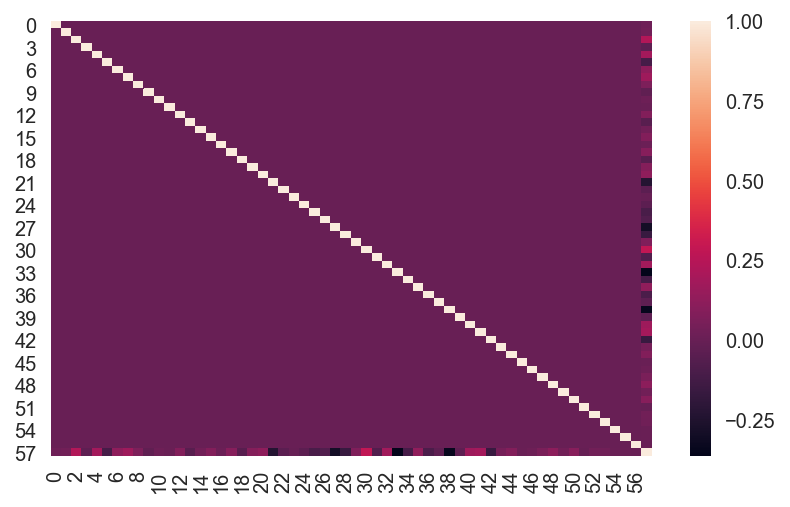

In [66]:
# plot heatmap to confirm no co-correlation of features
sns.heatmap(np.corrcoef(lang_to_pcs.T))
plt.show()

In [67]:
# pairplots
#sns.pairplot(pd.DataFrame(lang_to_pcs, columns=['PC1','PC2','PC3','PC4','PC5',\
#                                                'PC6','PC7','PC8','PC9','PC10',\
#                                                'PC11','PC12','PC13','PC14','PC15',\
#                                                'PC16','PC17','PC18','PC19','PC20']), kind='reg');

In [68]:
y_df = pd.DataFrame(y_train)

In [69]:
y_df.shape

(7000, 1)

In [70]:
# Extract the principal components and put them into a dataframe
lang_dict = {'PC'+str(i+1) : pca.components_[i] for i in range(len(pca.components_))}
pca_df = pd.DataFrame(lang_dict,index=X_train.columns)

In [71]:
# create a DataFrame with the principal components
lang_to_pcs = pd.DataFrame(lang_to_pcs, 
                        columns=['PC'+str(i) for i in range(1, lang_to_pcs.shape[1]+1)])

lang_to_pcs['Target_All'] = y_train

In [72]:
y_train.value_counts()

0    4777
1    2223
Name: Target_All, dtype: int64

In [73]:
lang_to_pcs.Target_All.value_counts()

0.0    633
1.0    285
Name: Target_All, dtype: int64

In [74]:
pca_df.shape

(58, 58)

In [75]:
pca_df.head()

PC1      PC10  \
SQt31i09_target_lang_website_freq                   0.176109 -0.157535   
SQt31i02_target_lang_movies_no_subtitles_freq       0.169323 -0.058914   
SQt31i04_target_lang_tv_no_subtitles_freq           0.159217 -0.068471   
I09_ST_M_S33B_indicator_for_perception_usefulne...  0.181230  0.010017   
SQtA4i03_target_lang_can_maintain_conversation_...  0.134464  0.055987   

                                                        PC11      PC12  \
SQt31i09_target_lang_website_freq                  -0.005334  0.078555   
SQt31i02_target_lang_movies_no_subtitles_freq       0.006669 -0.037757   
SQt31i04_target_lang_tv_no_subtitles_freq           0.062132 -0.021788   
I09_ST_M_S33B_indicator_for_perception_usefulne... -0.146027 -0.138031   
SQtA4i03_target_lang_can_maintain_conversation_... -0.100238  0.035586   

                                                        PC13      PC14  \
SQt31i09_target_lang_website_freq                  -0.089750 -0.060300   
SQt31i02_target_lang_movies_no_subtitles_freq       0.074892  0.067783   
SQt31i04_target_lang_tv_no_subtitles_freq           0.123585  0.055684   
I09_ST_M_S33B_indicator_for_perception_usefulne... -0.016154 -0.000550   
SQtA4i03_target_lang_can_maintain_conversation_... -0.088712  0.079666   

                                                        PC15      PC16  \
SQt31i09_target_lang_website_freq                   0.062823  0.016577   
SQt31i02_target_lang_movies_no_subtitles_freq      -0.003518 -0.081462   
SQt31i04_target_lang_tv_no_subtitles_freq          -0.065698 -0.086347   
I09_ST_M_S33B_indicator_for_perception_usefulne...  0.062945 -0.058353   
SQtA4i03_target_lang_can_maintain_conversation_... -0.093410  0.072691   

                                                        PC17      PC18  \
SQt31i09_target_lang_website_freq                   0.019869 -0.032037   
SQt31i02_target_lang_movies_no_subtitles_freq       0.108347 -0.137574   
SQt31i04_target_lang_tv_no_subtitles_freq           0.142543 -0.146592   
I09_ST_M_S33B_indicator_for_perception_usefulne...  0.114903 -0.072582   
SQtA4i03_target_lang_can_maintain_conversation_...  0.132329  0.194441   

                                                        PC19       PC2  \
SQt31i09_target_lang_website_freq                  -0.039356  0.133668   
SQt31i02_target_lang_movies_no_subtitles_freq      -0.028228  0.094429   
SQt31i04_target_lang_tv_no_subtitles_freq           0.005307  0.075253   
I09_ST_M_S33B_indicator_for_perception_usefulne... -0.088552  0.092095   
SQtA4i03_target_lang_can_maintain_conversation_... -0.292374 -0.131607   

                                                        PC20      PC21  \
SQt31i09_target_lang_website_freq                   0.019266  0.022929   
SQt31i02_target_lang_movies_no_subtitles_freq      -0.053383 -0.107974   
SQt31i04_target_lang_tv_no_subtitles_freq          -0.043143 -0.108357   
I09_ST_M_S33B_indicator_for_perception_usefulne... -0.193861  0.116648   
SQtA4i03_target_lang_can_maintain_conversation_...  0.142071 -0.061170   

                                                        PC22      PC23  \
SQt31i09_target_lang_website_freq                   0.040658 -0.086208   
SQt31i02_target_lang_movies_no_subtitles_freq       0.028101  0.261722   
SQt31i04_target_lang_tv_no_subtitles_freq           0.018056  0.384315   
I09_ST_M_S33B_indicator_for_perception_usefulne...  0.031551  0.003353   
SQtA4i03_target_lang_can_maintain_conversation_...  0.260363 -0.043235   

                                                        PC24      PC25  \
SQt31i09_target_lang_website_freq                   0.065512  0.155777   
SQt31i02_target_lang_movies_no_subtitles_freq      -0.101190 -0.023588   
SQt31i04_target_lang_tv_no_subtitles_freq          -0.126578 -0.124139   
I09_ST_M_S33B_indicator_for_perception_usefulne... -0.002027  0.018228   
SQtA4i03_target_lang_can_maintain_conversation_...  0.103062 -0.017748   

                                                    

In [76]:
X_train_ss.shape, lang_exp_var_pct.shape

((7000, 58), (58,))

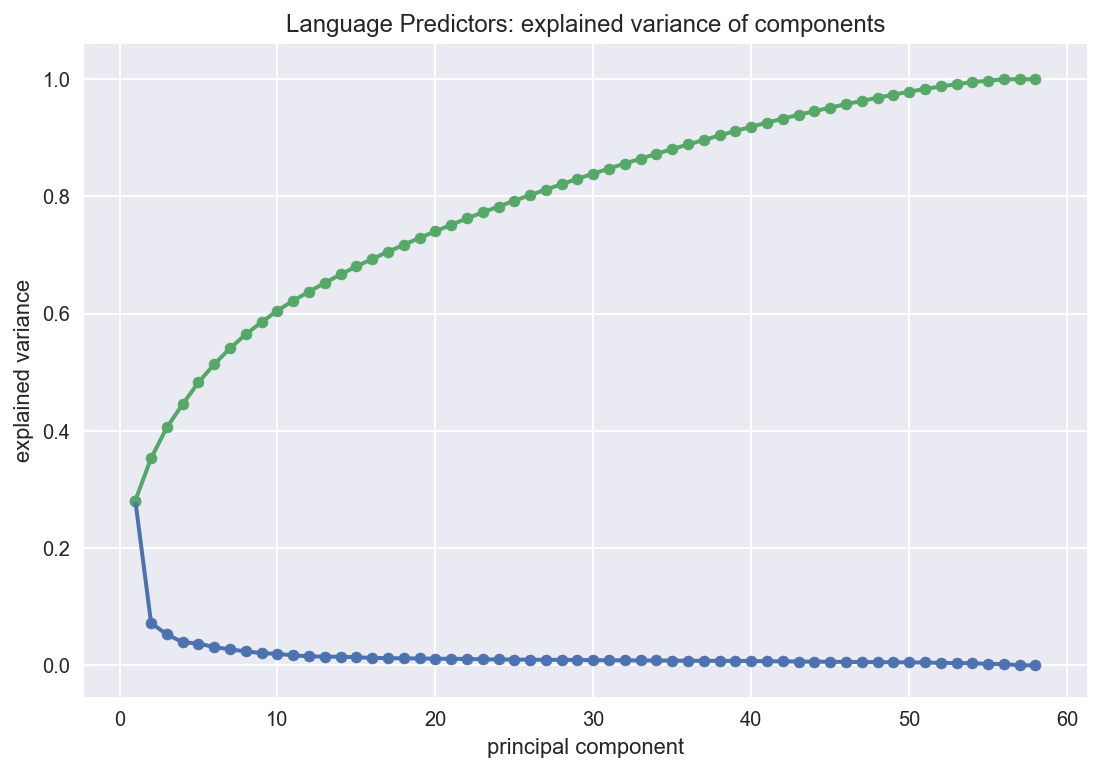

In [77]:
fig, ax = plt.subplots(figsize=(8,6))

x_values = list(range(1, pca.n_components_+1))

ax.plot(x_values, pca.explained_variance_ratio_, lw=2)
ax.scatter(x_values, pca.explained_variance_ratio_, s=30)
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2)
ax.scatter(x_values, np.cumsum(pca.explained_variance_ratio_), s=30)
ax.set_title('Language Predictors: explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()

In [78]:
pd.DataFrame(pca.components_.T, index=X_train.columns)

0         1   \
SQt31i09_target_lang_website_freq                   0.176109  0.133668   
SQt31i02_target_lang_movies_no_subtitles_freq       0.169323  0.094429   
SQt31i04_target_lang_tv_no_subtitles_freq           0.159217  0.075253   
I09_ST_M_S33B_indicator_for_perception_usefulne...  0.181230  0.092095   
SQtA4i03_target_lang_can_maintain_conversation_...  0.134464 -0.131607   
SQtA4i04_target_lang_can_explain_viewpoint_adva...  0.136156 -0.095757   
SQt31i01_target_lang_songs_freq                     0.147055  0.174689   
SQt33i10_target_lang_usefulness_entertainment       0.161122  0.164374   
SQtA2i03_target_lang_can_understand_radio_TV_pr...  0.124243 -0.112428   
SQtA3i03_target_lang_can_write_detailed_letters...  0.132460 -0.112124   
SQt34i06_enjoyment_target_lang                      0.152763 -0.042036   
SQt31i08_target_lang_mag_comic_freq                 0.147079  0.071747   
SQt33i08_target_lang_usefulness_computers           0.160143  0.189318   
SQt30i01_target_lang_write_friends_freq             0.154759  0.108813   
SQt28i02_target_lang_level_mother                   0.098451 -0.026825   
SQt28i01_target_lang_level_father                   0.094271 -0.034239   
SQt31i05_target_lang_tv_subtitles_freq              0.131043  0.145096   
SQtA2i04_target_lang_can_understand_long_compli...  0.127142 -0.090399   
SQt32i04_perceived_competence_self                  0.115917 -0.133686   
SQt30i06_target_lang_speak_internet_freq            0.146971  0.134728   
SQtA3i04_target_lang_can_write_detailed_review_...  0.123929 -0.081310   
SQtA4i02_target_lang_can_tell_simple_story          0.106609 -0.141418   
SQt30i03_target_lang_speak_friends_freq             0.148274  0.078895   
I03_ST_A_S29A_target_lang_exposure_through_home...  0.159866  0.103092   
SQt33i09_target_lang_usefulness_reading             0.144635  0.138392   
SQt31i07_target_lang_books_freq                     0.128673  0.040244   
SQt31i03_target_lang_movies_subtitles_freq          0.130634  0.174371   
SQt35i06_usefulness_target_lang                     0.136489  0.110495   
SQt33i02_target_lang_usefulness_personal_life       0.149132  0.137289   
SQt33i07_target_lang_usefulness_satisfaction        0.145013  0.111392   
SQt31i06_target_lang_games_freq                     0.140252  0.162118   
SQtA1i04_target_lang_can_read_long_complex_text...  0.120850 -0.135812   
SQt33i01_target_lang_usefulness_travel              0.127397  0.118891   
SQtA1i03_target_lang_can_find_main_points_simpl...  0.098295 -0.150133   
I08_ST_A_S19B_economic_social_cultural_status       0.048870 -0.105598   
SQt29i01_target_lang_exposure_penfriend             0.129758  0.088409   
SQt55i05_perception_target_lang_lessons_easy        0.109506 -0.106360   
SQt30i05_target_lang_speak_tourists_freq            0.124150  0.079482   
SQtA3i02_target_lang_can_write_basic_descriptio...  0.094963 -0.129750   
SQtA1i02_target_lang_can_find_info_ads_timetabl...  0.093596 -0.131112   
SQt33i05_target_lang_usefulness_getting_job         0.124509  0.144003   
I03_ST_A_S26B_target_lang_used_home                 0.099831  0.007823   
SQt26i05_lang_used_at_home_target                   0.099831  0.007823   
SQtA2i01_target_lang_can_understand_qs_instruct...  0.090190 -0.136047   
SQt29i07_target_lang_holidays                       0.098850  0.022531   
SQt33i06_target_lang_usefulness_contact_foreigners  0.110202  0.116083   
SQt30i02_target_lang_speak_relatives_freq           0.123971  0.042494   
SQt29i06_target_lang_internet                       0.117364  0.122981   
SQtA2i02_target_lang_can_understand_if_spoken_s...  0.088107 -0.142276   
HISEI_highest_occupational_status                   0.030172 -0.090900   
SQt48i06_perceived_difficulty_target_lang_pronu... -0.122187  0.223926   
SQt48i04_perceived_difficulty_target_lang_grammar  -0.114200  0.184486   
SQt48i07_perceived_difficulty_target_lang_vocab    -0.128528  0.198498   
SQt48i01_perceived_difficulty_target_lang_writing  -0.137663  

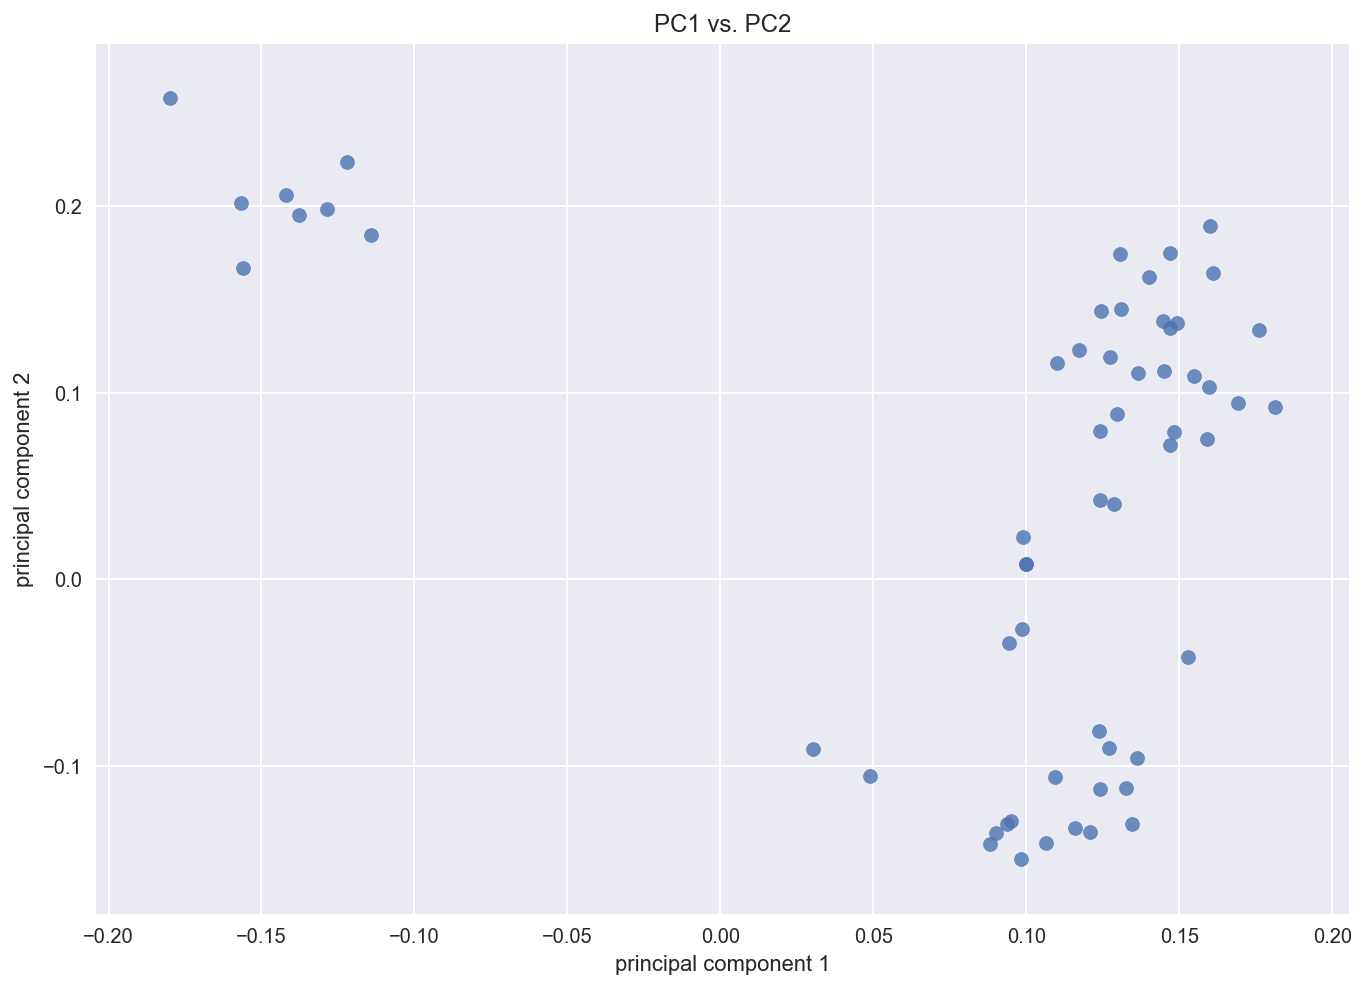

In [79]:
# plot PC1 against PC2
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pca_df.PC1, pca_df.PC2, alpha=0.8)

ax.set_title('PC1 vs. PC2')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()

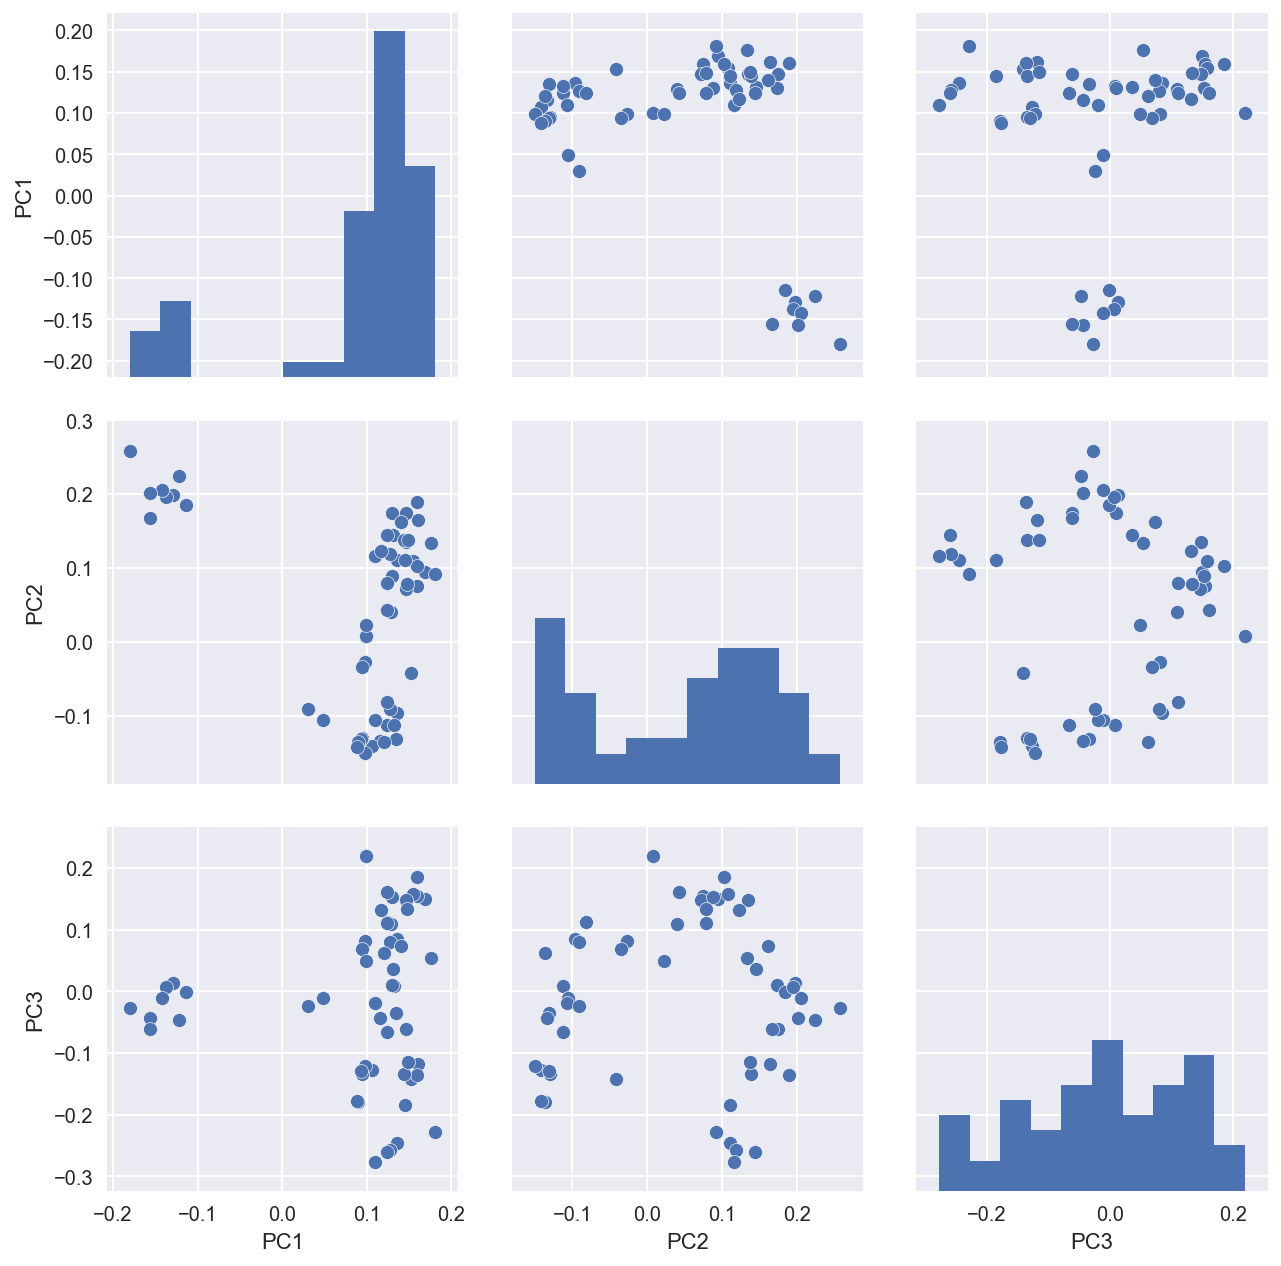

In [80]:
sns.pairplot(data=pca_df, vars=['PC1','PC2','PC3'], size=3);

## Gridsearch on Sample Subset (10k observations)

In [81]:
def print_cm_cr(y_true, y_pred):
    """prints the confusion matrix and the classification report"""
    confusion = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=[
                            'Predicted'], margins=True)
    print(confusion)
    print()
    print(classification_report(y_true, y_pred))

Link to notebook with original function (I will delete this once I'm comfortable I haven't forgotten anything!)

http://localhost:8888/notebooks/DSI5-lessons/week11/day2_support_vector_machines/support-vector-machines-lab-2/solution-code/svm-lab-solution-code.ipynb

In [82]:
# function to generalise gridsearch and scoring
def grid_search_func(estimator, params, X_train, y_train,\
                     X_test, y_test, scoring_function=accuracy_score,\
                     scoring='accuracy'):
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        n_jobs=6, cv=4,
        return_train_score=True,
        scoring=scoring,
        verbose=2)

    gs.fit(X_train, y_train)

    print("Best score:")
    print(gs.best_score_)
    print()
    print("Best estimator:")
    print(gs.best_estimator_.get_params())
    print()

    predictions = gs.best_estimator_.predict(X_test)
    print('Test score: ', scoring_function(y_test, predictions))
    print()
    print_cm_cr(y_test, predictions)

    return gs

### Logistic Regression

In [83]:
# initiate model and cross validate
model_lr = LogisticRegression(solver='lbfgs')
model_lr.fit(X_train_ss, y_train)
predictions_lr = model_lr.predict(X_test_ss)

print('Mean Cross Val Score:\t', cross_val_score(model_lr, X_train_ss, y_train, cv=5).mean())
#print('Score (Test Data):\t', lr.score(X_test_ss, y_test))
print('Accuracy Score:\t', accuracy_score(y_test, predictions_lr))

Mean Cross Val Score:	 0.8178627830932566
Accuracy Score:	 0.8183333333333334


In [84]:
# instantiate Logistic Regression
lr = LogisticRegression()

In [125]:
# create a hyperparameter dictionary for logistic regression
lr_params = {#'penalty':['l2'],\
#             'solver':['lbfgs', 'sag'],\
             'C':np.logspace(-3,2,5)}

#### Action
Gridsearch keeps getting stuck so I need to figure out how to tune it to run successfully.

In [126]:
# run gridsearch for Logistic Regression
gs_lr = grid_search_func(lr,lr_params,\
                         X_train_ss,y_train,X_test_ss,y_test)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.001 .........................................................
[CV] C=0.01778279410038923 ...........................................
[CV] C=0.01778279410038923 ...........................................
[CV] C=0.01778279410038923 ...........................................
[CV] C=0.01778279410038923 ...........................................
[CV] C=0.31622776601683794 ...........................................
[CV] C=0.31622776601683794 ...........................................
[CV] C=0.31622776601683794 ...........................................
[CV] C=0.31622776601683794 ...........................................


Process ForkPoolWorker-117:
Process ForkPoolWorker-116:
Process ForkPoolWorker-119:
Process ForkPoolWorker-120:
Process ForkPoolWorker-118:
Process ForkPoolWorker-115:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anacon

KeyboardInterrupt: 

### KNN Classifier

In [ ]:
#### Try KNN with cosine similarity as distance metric for multiclass?

In [127]:
# instantiate KNN model
model_knn = KNeighborsClassifier()

In [128]:
# set hyperparameters for gridsearch
params_knn = {'n_neighbors':list(range(1,21,3)),
              'weights':['distance','uniform']}

In [129]:
# run gridsearch for KNN
gs_knn = grid_search_func(model_knn, params_knn,\
                          X_train_ss, y_train, X_test_ss, y_test)

Fitting 4 folds for each of 14 candidates, totalling 56 fits
[CV] n_neighbors=1, weights=distance .................................
[CV] n_neighbors=1, weights=distance .................................
[CV] n_neighbors=1, weights=distance .................................
[CV] n_neighbors=1, weights=distance .................................
[CV] n_neighbors=1, weights=uniform ..................................
[CV] n_neighbors=1, weights=uniform ..................................
[CV] .................. n_neighbors=1, weights=distance, total=   2.2s
[CV] .................. n_neighbors=1, weights=distance, total=   2.3s
[CV] .................. n_neighbors=1, weights=distance, total=   2.2s
[CV] n_neighbors=1, weights=uniform ..................................
[CV] n_neighbors=1, weights=uniform ..................................
[CV] n_neighbors=4, weights=distance .................................
[CV] ................... n_neighbors=1, weights=uniform, total=   2.2s
[CV] n_neighbors

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   38.5s


[CV] .................. n_neighbors=10, weights=uniform, total=   2.2s
[CV] n_neighbors=13, weights=uniform .................................
[CV] .................. n_neighbors=10, weights=uniform, total=   2.1s
[CV] n_neighbors=13, weights=uniform .................................
[CV] ................. n_neighbors=13, weights=distance, total=   2.3s
[CV] n_neighbors=13, weights=uniform .................................
[CV] ................. n_neighbors=13, weights=distance, total=   2.3s
[CV] n_neighbors=13, weights=uniform .................................
[CV] ................. n_neighbors=13, weights=distance, total=   2.2s
[CV] n_neighbors=16, weights=distance ................................
[CV] ................. n_neighbors=13, weights=distance, total=   2.3s
[CV] n_neighbors=16, weights=distance ................................
[CV] .................. n_neighbors=13, weights=uniform, total=   2.2s
[CV] n_neighbors=16, weights=distance ................................
[CV] .

[Parallel(n_jobs=6)]: Done  56 out of  56 | elapsed:  1.3min finished


Best score:
0.8014285714285714

Best estimator:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}

Test score:  0.8013333333333333

Predicted     0    1   All
Actual                    
0          1806  241  2047
1           355  598   953
All        2161  839  3000

             precision    recall  f1-score   support

          0       0.84      0.88      0.86      2047
          1       0.71      0.63      0.67       953

avg / total       0.80      0.80      0.80      3000



### Linear SVM

In [130]:
# instantiate linear SVC
model_lin = svm.LinearSVC()

In [131]:
# set hyperparameters for gridsearch
params_lin = {'C': np.logspace(-10, 10, 21),
              'fit_intercept': [True, False]}

In [132]:
# run gridsearch function for Linear SVM
gs_lin = grid_search_func(model_lin, params_lin,
                          X_train_ss, y_train, X_test_ss, y_test,
                          scoring_function=accuracy_score,
                          scoring='accuracy')

Fitting 4 folds for each of 42 candidates, totalling 168 fits
[CV] C=1e-10, fit_intercept=True .....................................
[CV] C=1e-10, fit_intercept=True .....................................
[CV] C=1e-10, fit_intercept=True .....................................
[CV] C=1e-10, fit_intercept=True .....................................
[CV] C=1e-10, fit_intercept=False ....................................
[CV] C=1e-10, fit_intercept=False ....................................
[CV] C=1e-10, fit_intercept=False ....................................
[CV] C=1e-10, fit_intercept=False ....................................
[CV] C=1e-09, fit_intercept=True .....................................
[CV] C=1e-09, fit_intercept=True .....................................
[CV] C=1e-09, fit_intercept=True .....................................
[CV] C=1e-09, fit_intercept=True .....................................


Process ForkPoolWorker-139:
Process ForkPoolWorker-141:
Process ForkPoolWorker-144:
Process ForkPoolWorker-142:
Process ForkPoolWorker-140:
Process ForkPoolWorker-143:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lizspiking/anacon

KeyboardInterrupt: 

In [ ]:
# run gridsearch function for Linear SVM with precision scoring
gs_lin_pr = grid_search_func(model_lin, params_lin,
                          X_train_ss, y_train, X_test_ss, y_test,
                          scoring_function=precision_score,
                          scoring='precision')

#### Action
Gridsearch keeps stalling on this model too; figure out how to tune it to allow it to run sucessfully.

In [ ]:
#model_lin.fit()

### Support Vector Classifier with rbf kernel

In [118]:
# instantiate SVM with rbf kernel
model_rbf = svm.SVC(kernel='rbf')

In [119]:
# create hyperparameter dictionary for gridsearch
params_rbf = {'C': np.logspace(-3,2,5),
              'gamma':np.logspace(-5,2,5)}

In [120]:
# run gridsearch function for SVM with rbf kernel
gs_rbf = grid_search_func(model_rbf, params_rbf,\
                          X_train_ss, y_train, X_test_ss, y_test)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total=   4.0s
[CV] ............................. C=0.001, gamma=1e-05, total=   4.0s
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total=   4.0s
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] ............................. C=0.001, gamma=1e-05, total=   4.1s
[CV] C=0.001, g

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   29.8s


[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=   4.0s
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=   4.0s
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=   5.2s
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=   5.2s
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=   5.1s
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=   5.1s
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] ............... C=0.01778279410038923, gamma=100.0, total=   4.1s
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .

[CV] ............... C=100.0, gamma=0.03162277660168379, total=   5.1s
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total=   5.1s
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total=   5.3s
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............... C=100.0, gamma=0.03162277660168379, total=   5.4s
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total=   6.0s
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total=   6.1s
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total=   6.2s
[CV] ................ C=100.0, gamma=1.7782794100389228, total=   6.3s
[CV] .

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:  1.8min finished


Best score:
0.8188571428571428

Best estimator:
{'C': 100.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0005623413251903491, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Test score:  0.819

Predicted     0    1   All
Actual                    
0          1884  163  2047
1           380  573   953
All        2264  736  3000

             precision    recall  f1-score   support

          0       0.83      0.92      0.87      2047
          1       0.78      0.60      0.68       953

avg / total       0.82      0.82      0.81      3000



In [121]:
# run gridsearch function for SVM with rbf kernel and precision scoring
gs_rbf_pr = grid_search_func(model_rbf, params_rbf,
                          X_train_ss, y_train, X_test_ss, y_test,
                          scoring_function=precision_score,
                          scoring='precision')

Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/

[CV] ............................. C=0.001, gamma=1e-05, total=   3.5s
[CV] ............................. C=0.001, gamma=1e-05, total=   3.6s
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............. C=0.001, gamma=0.0005623413251903491, total=   3.6s
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] ............................. C=0.001, gamma=1e-05, total=   3.6s
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] ............................. C=0.001, gamma=1e-05, total=   3.6s
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] ............. C=0.001, gamma=0.0005623413251903491, total=   3.6s
[CV] C=0.001, gamma=0.03162277660168379 ..............................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/

[CV] ............. C=0.001, gamma=0.0005623413251903491, total=   3.6s
[CV] C=0.001, gamma=1.7782794100389228 ...............................
[CV] ............. C=0.001, gamma=0.0005623413251903491, total=   3.7s
[CV] C=0.001, gamma=1.7782794100389228 ...............................
[CV] ............... C=0.001, gamma=0.03162277660168379, total=   3.7s
[CV] C=0.001, gamma=1.7782794100389228 ...............................
[CV] ............... C=0.001, gamma=0.03162277660168379, total=   3.7s
[CV] C=0.001, gamma=1.7782794100389228 ...............................
[CV] ............... C=0.001, gamma=0.03162277660168379, total=   3.8s
[CV] C=0.001, gamma=100.0 ............................................
[CV] ............... C=0.001, gamma=0.03162277660168379, total=   3.8s
[CV] C=0.001, gamma=100.0 ............................................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/

[CV] ............................. C=0.001, gamma=100.0, total=   3.5s
[CV] C=0.001, gamma=100.0 ............................................
[CV] ............................. C=0.001, gamma=100.0, total=   3.6s
[CV] C=0.001, gamma=100.0 ............................................
[CV] ................ C=0.001, gamma=1.7782794100389228, total=   4.3s
[CV] C=0.01778279410038923, gamma=1e-05 ..............................
[CV] ................ C=0.001, gamma=1.7782794100389228, total=   4.4s
[CV] C=0.01778279410038923, gamma=1e-05 ..............................
[CV] ................ C=0.001, gamma=1.7782794100389228, total=   4.3s
[CV] C=0.01778279410038923, gamma=1e-05 ..............................
[CV] ................ C=0.001, gamma=1.7782794100389228, total=   4.3s
[CV] C=0.01778279410038923, gamma=1e-05 ..............................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/

[CV] ............................. C=0.001, gamma=100.0, total=   3.9s
[CV] C=0.01778279410038923, gamma=0.0005623413251903491 ..............
[CV] ............... C=0.01778279410038923, gamma=1e-05, total=   3.7s
[CV] C=0.01778279410038923, gamma=0.0005623413251903491 ..............
[CV] ............... C=0.01778279410038923, gamma=1e-05, total=   3.7s
[CV] C=0.01778279410038923, gamma=0.0005623413251903491 ..............
[CV] ............................. C=0.001, gamma=100.0, total=   4.0s
[CV] ............... C=0.01778279410038923, gamma=1e-05, total=   3.8s
[CV] C=0.01778279410038923, gamma=0.0005623413251903491 ..............
[CV] C=0.01778279410038923, gamma=0.03162277660168379 ................
[CV] ............... C=0.01778279410038923, gamma=1e-05, total=   3.7s
[CV] C=0.01778279410038923, gamma=0.03162277660168379 ................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  C=0.01778279410038923, gamma=0.0005623413251903491, total=   3.9s
[CV] C=0.01778279410038923, gamma=0.03162277660168379 ................
[CV]  C=0.01778279410038923, gamma=0.0005623413251903491, total=   3.8s
[CV]  C=0.01778279410038923, gamma=0.0005623413251903491, total=   3.8s
[CV] C=0.01778279410038923, gamma=0.03162277660168379 ................
[CV] C=0.01778279410038923, gamma=1.7782794100389228 .................
[CV]  C=0.01778279410038923, gamma=0.0005623413251903491, total=   3.9s
[CV] C=0.01778279410038923, gamma=1.7782794100389228 .................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=   3.9s
[CV] C=0.01778279410038923, gamma=1.7782794100389228 .................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=   3.9s
[CV] C=0.01778279410038923, gamma=1.7782794100389228 .................


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   29.1s
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pr

[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=   3.4s
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=   3.5s
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=   4.5s
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=   4.6s
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=   4.5s
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=   4.5s
[CV] C=0.31622776601683794, gamma=1e-05 ..............................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/

[CV] ............... C=0.01778279410038923, gamma=100.0, total=   3.6s
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] ............... C=0.01778279410038923, gamma=100.0, total=   3.7s
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] ............... C=0.31622776601683794, gamma=1e-05, total=   3.3s
[CV] C=0.31622776601683794, gamma=0.0005623413251903491 ..............
[CV] ............... C=0.31622776601683794, gamma=1e-05, total=   3.3s
[CV] C=0.31622776601683794, gamma=0.0005623413251903491 ..............
[CV] ............... C=0.01778279410038923, gamma=100.0, total=   3.9s
[CV] C=0.31622776601683794, gamma=0.0005623413251903491 ..............
[CV] ............... C=0.01778279410038923, gamma=100.0, total=   3.9s
[CV] C=0.31622776601683794, gamma=0.0005623413251903491 ..............


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=0.31622776601683794, gamma=1e-05, total=   3.2s
[CV] C=0.31622776601683794, gamma=0.03162277660168379 ................
[CV] ............... C=0.31622776601683794, gamma=1e-05, total=   3.2s
[CV] C=0.31622776601683794, gamma=0.03162277660168379 ................
[CV]  C=0.31622776601683794, gamma=0.0005623413251903491, total=   2.8s
[CV] C=0.31622776601683794, gamma=0.03162277660168379 ................
[CV]  C=0.31622776601683794, gamma=0.0005623413251903491, total=   2.9s
[CV] C=0.31622776601683794, gamma=0.03162277660168379 ................
[CV]  C=0.31622776601683794, gamma=0.0005623413251903491, total=   2.7s
[CV] C=0.31622776601683794, gamma=1.7782794100389228 .................
[CV]  C=0.31622776601683794, gamma=0.0005623413251903491, total=   2.7s
[CV] C=0.31622776601683794, gamma=1.7782794100389228 .................
[CV] . C=0.31622776601683794, gamma=0.03162277660168379, total=   3.0s
[CV] C=0.31622776601683794, gamma=1.7782794100389228 .................
[C

/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .. C=0.31622776601683794, gamma=1.7782794100389228, total=   4.4s
[CV] C=0.31622776601683794, gamma=100.0 ..............................
[CV] .. C=0.31622776601683794, gamma=1.7782794100389228, total=   4.6s
[CV] C=0.31622776601683794, gamma=100.0 ..............................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=0.31622776601683794, gamma=100.0, total=   3.7s
[CV] C=5.623413251903491, gamma=1e-05 ................................
[CV] ............... C=0.31622776601683794, gamma=100.0, total=   3.8s
[CV] C=5.623413251903491, gamma=1e-05 ................................
[CV] .. C=0.31622776601683794, gamma=1.7782794100389228, total=   4.6s
[CV] C=5.623413251903491, gamma=1e-05 ................................
[CV] .. C=0.31622776601683794, gamma=1.7782794100389228, total=   4.6s
[CV] C=5.623413251903491, gamma=1e-05 ................................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=0.31622776601683794, gamma=100.0, total=   4.4s
[CV] C=5.623413251903491, gamma=0.0005623413251903491 ................
[CV] ............... C=0.31622776601683794, gamma=100.0, total=   4.5s
[CV] C=5.623413251903491, gamma=0.0005623413251903491 ................
[CV] ................. C=5.623413251903491, gamma=1e-05, total=   3.5s
[CV] C=5.623413251903491, gamma=0.0005623413251903491 ................
[CV] ................. C=5.623413251903491, gamma=1e-05, total=   3.5s
[CV] C=5.623413251903491, gamma=0.0005623413251903491 ................
[CV] ................. C=5.623413251903491, gamma=1e-05, total=   3.4s
[CV] C=5.623413251903491, gamma=0.03162277660168379 ..................
[CV] ................. C=5.623413251903491, gamma=1e-05, total=   3.4s
[CV] C=5.623413251903491, gamma=0.03162277660168379 ..................
[CV] . C=5.623413251903491, gamma=0.0005623413251903491, total=   3.0s
[CV] C=5.623413251903491, gamma=0.03162277660168379 ..................
[CV] .

/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ... C=5.623413251903491, gamma=0.03162277660168379, total=   5.3s
[CV] C=5.623413251903491, gamma=100.0 ................................
[CV] ... C=5.623413251903491, gamma=0.03162277660168379, total=   5.4s
[CV] C=5.623413251903491, gamma=100.0 ................................
[CV] .... C=5.623413251903491, gamma=1.7782794100389228, total=   5.9s
[CV] C=5.623413251903491, gamma=100.0 ................................
[CV] .... C=5.623413251903491, gamma=1.7782794100389228, total=   5.9s
[CV] C=5.623413251903491, gamma=100.0 ................................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] .... C=5.623413251903491, gamma=1.7782794100389228, total=   5.4s
[CV] C=100.0, gamma=1e-05 ............................................
[CV] .... C=5.623413251903491, gamma=1.7782794100389228, total=   5.5s
[CV] C=100.0, gamma=1e-05 ............................................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................. C=5.623413251903491, gamma=100.0, total=   4.7s
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ................. C=5.623413251903491, gamma=100.0, total=   4.6s
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ................. C=5.623413251903491, gamma=100.0, total=   4.6s
[CV] C=100.0, gamma=0.0005623413251903491 ............................
[CV] ................. C=5.623413251903491, gamma=100.0, total=   4.6s
[CV] C=100.0, gamma=0.0005623413251903491 ............................
[CV] ............................. C=100.0, gamma=1e-05, total=   2.4s
[CV] C=100.0, gamma=0.0005623413251903491 ............................
[CV] ............................. C=100.0, gamma=1e-05, total=   2.4s
[CV] C=100.0, gamma=0.0005623413251903491 ............................
[CV] ............................. C=100.0, gamma=1e-05, total=   2.3s
[CV] C=100.0, gamma=0.03162277660168379 ..............................
[CV] .

/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............... C=100.0, gamma=0.03162277660168379, total=   4.9s
[CV] ............... C=100.0, gamma=0.03162277660168379, total=   4.8s
[CV] C=100.0, gamma=100.0 ............................................
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total=   5.5s
[CV] ................ C=100.0, gamma=1.7782794100389228, total=   5.3s
[CV] C=100.0, gamma=100.0 ............................................
[CV] C=100.0, gamma=100.0 ............................................


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ................ C=100.0, gamma=1.7782794100389228, total=   5.6s
[CV] ................ C=100.0, gamma=1.7782794100389228, total=   5.7s


/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lizspiking/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV] ............................. C=100.0, gamma=100.0, total=   4.7s
[CV] ............................. C=100.0, gamma=100.0, total=   4.8s
[CV] ............................. C=100.0, gamma=100.0, total=   4.4s
[CV] ............................. C=100.0, gamma=100.0, total=   4.5s


[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:  1.7min finished


Best score:
0.8655761801802327

Best estimator:
{'C': 0.01778279410038923, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.03162277660168379, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Test score:  0.8318385650224215

Predicted     0    1   All
Actual                    
0          1972   75  2047
1           582  371   953
All        2554  446  3000

             precision    recall  f1-score   support

          0       0.77      0.96      0.86      2047
          1       0.83      0.39      0.53       953

avg / total       0.79      0.78      0.75      3000



### Decision Tree Classifier

In [23]:
# fit model and get predictions
#dtc.fit(X_train_ss, y_train)
#predictions_dtc = dtc.predict(X_test_ss)

In [87]:
# instantiate Decision Tree model
dtc = DecisionTreeClassifier(random_state=7)

In [88]:
# create hyperparameter dictionary for gridsearch
params_dtc = {'max_depth': [7, 10, 11, 20, 30],
              'max_features': [10, 20, 'log2', 'sqrt']}

In [89]:
dtc.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [90]:
# run gridsearch function for Decision Tree
gs_dtc = grid_search_func(dtc, params_dtc,\
                          X_train_ss, y_train, X_test_ss, y_test)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] max_depth=7, max_features=log2 ..................................
[CV] ...........

[CV] max_depth=30, max_features=20 ...................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] max_depth=20, max_features=20 ...................................
[CV] .................... max_depth=20, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] max_depth=20, max_features=log2 .................................
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] m

[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.7s finished


In [91]:
# set predictions
predictions_dt = gs_dtc.predict(X_test_ss)

In [92]:
print('Training data: ')
print('Mean CV Accuracy Score:\t', np.mean(cross_val_score(gs_dtc,X_train_ss,y_train,cv=5)).round(4))
print('----------------------------------------')
print('Test data:\t')
print('Accuracy:\t', gs_dtc.score(X_test_ss, y_test).round(4))
print('F1 Score:\t', f1_score(y_test, predictions_dt, average='binary').round(4))
print('Precision Score:\t', precision_score(y_test, predictions_dt, average='binary').round(4))

Training data: 
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=log2 ..................................


[CV] max_depth=20, max_features=10 ...................................
[CV] .................... max_depth=11, max_features=20, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] max_depth=20, max_features=20 ...................................
[CV] .................... max_depth=30, max_features=20, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................... max_depth=20, max_features=10, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] m

[Parallel(n_jobs=6)]: Done  28 out of  80 | elapsed:    0.3s remaining:    0.5s


[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=sqrt .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................. max_depth=30, max_features=sqrt, total=   0.0s
[CV] m

[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.6s finished


[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=log2 ..................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=20, total=   0.0s
[CV] m

[CV] max_depth=20, max_features=sqrt .................................
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] max_depth=20, max_features=log2 .................................
[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] max_depth=20, max_features=20 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=20, max_features=10, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] .

[Parallel(n_jobs=6)]: Done  28 out of  80 | elapsed:    0.3s remaining:    0.5s


[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=sqrt, total=   0.0s
[CV] max_depth=30, max_features=sqrt .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................. max_depth=30, max_features=sqrt, total=   0.0s
[CV] .................... max_depth=30, max_features=20, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................... max_depth=30, max_features=20, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................... max_depth=30, max_features=20, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................... max_depth=30, max_features=20, total=   0.0s
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.6s finished


[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=log2 ..................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=20, total=   0.0s
[CV] m

[CV] .................... max_depth=20, max_features=10, total=   0.0s
[CV] .................... max_depth=11, max_features=20, total=   0.0s
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=log2 .................................
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................... max_depth=30, max_features=20, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=20 ...................................
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] m

[Parallel(n_jobs=6)]: Done  28 out of  80 | elapsed:    0.3s remaining:    0.5s


[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=sqrt .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] m

[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.6s finished


[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=20, total=   0.0s
[CV] max_depth=7, max_features=log2 ..................................
[CV] .

[CV] .................... max_depth=11, max_features=20, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] .................... max_depth=20, max_features=10, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................... max_depth=30, max_features=20, total=   0.0s
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] max_depth=20, max_features=log2 .................................
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] max_depth=20, max_features=20 ...................................
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] m

[Parallel(n_jobs=6)]: Done  28 out of  80 | elapsed:    0.3s remaining:    0.5s


[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] m

[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.6s finished


Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=log2 ..................................
[CV] ...........

[CV] max_depth=20, max_features=20 ...................................
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................... max_depth=11, max_features=20, total=   0.0s
[CV] .................... max_depth=20, max_features=10, total=   0.0s
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] max_depth=20, max_features=log2 .................................
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................... max_depth=30, max_features=20, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................... max_depth=20, max_features=20, total=   0.0s
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] max_depth=20, max_features=20 ...................................
[CV] .

[Parallel(n_jobs=6)]: Done  28 out of  80 | elapsed:    0.3s remaining:    0.5s


[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=log2 .................................
[CV] max_depth=30, max_features=10 ...................................
[CV] .................. max_depth=30, max_features=log2, total=   0.0s
[CV] max_depth=30, max_features=sqrt .................................
[CV] .................... max_depth=30, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................. max_depth=30, max_features=sqrt, total=   0.0s
[CV] max_depth=30, max_features=sqrt .................................
[CV] .

[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.6s finished


In [93]:
gs_dtc.fit(X_train_ss, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=10 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=20 ....................................
[CV] ..................... max_depth=7, max_features=10, total=   0.0s
[CV] max_depth=7, max_features=log2 ..................................
[CV] max_depth=7

[CV] max_depth=20, max_features=log2 .................................
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................... max_depth=20, max_features=20, total=   0.1s
[CV] .................... max_depth=11, max_features=20, total=   0.0s
[CV] max_depth=20, max_features=20 ...................................
[CV] .................... max_depth=20, max_features=10, total=   0.0s
[CV] max_depth=30, max_features=sqrt .................................
[CV] .................... max_depth=30, max_features=20, total=   0.1s
[CV] max_depth=30, max_features=20 ...................................
[CV] .................. max_depth=20, max_features=log2, total=   0.0s
[CV] .................. max_depth=20, max_features=sqrt, total=   0.0s
[CV] max_depth=20, max_features=sqrt .................................
[CV] .................. max_depth=30, max_features=sqrt, total=   0.0s
[CV] m

[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    0.7s finished


GridSearchCV(cv=4, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=7,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [7, 10, 11, 20, 30], 'max_features': [10, 20, 'log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [94]:
gs_dtc.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=4, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=7,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [7, 10, 11, 20, 30], 'max_features': [10, 20, 'log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)>

In [95]:
# save DTC model with best hyperparameters
best_dtc = gs_dtc.best_estimator_
print('Best parameters: ', gs_dtc.best_params_)
print('Best Mean CV accuracy score:', gs_dtc.best_score_)
print('Accuracy test: ', gs_dtc.score(X_test_ss, y_test))

Best parameters:  {'max_depth': 7, 'max_features': 20}
Best Mean CV accuracy score: 0.7841428571428571
Accuracy test:  0.778


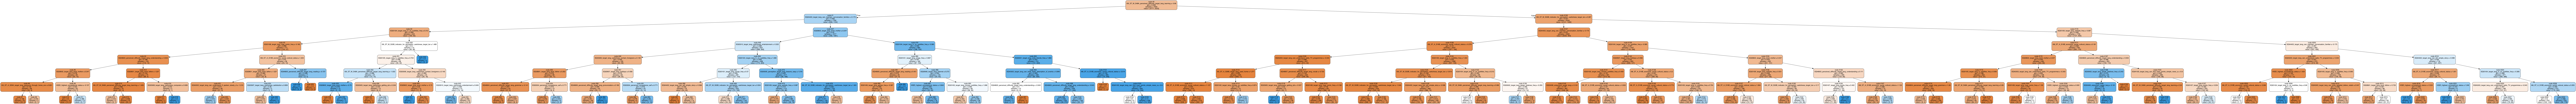

In [96]:
# display Decision Tree splits
dot_data = StringIO()  

export_graphviz(best_dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,\
                feature_names=X_train.columns,\
                node_ids=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [97]:
# create df showing features in order of impact on the model
importances_dt = pd.DataFrame(best_dtc.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
importances_dt.sort_values(by='importance', ascending=False).head(10)

importance
I09_ST_M_S48A_perceived_difficulty_target_lang_...    0.382575
SQtA4i03_target_lang_can_maintain_conversation_...    0.118670
I09_ST_M_S33B_indicator_for_perception_usefulne...    0.112652
SQt31i04_target_lang_tv_no_subtitles_freq             0.063877
I08_ST_A_S19B_economic_social_cultural_status         0.050603
SQt31i09_target_lang_website_freq                     0.040387
SQt28i02_target_lang_level_mother                     0.039350
SQt33i10_target_lang_usefulness_entertainment         0.023066
SQt31i01_target_lang_songs_freq                       0.020319
SQt31i05_target_lang_tv_subtitles_freq                0.014038

### Random Forest Classifier

In [98]:
# initiate Random Forest model
rf = RandomForestClassifier(random_state=7)

# fit random forest model
rf.fit(X_train_ss, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [100]:
# set hyperparameters for gridsearch on random forest
params_rf = {'n_estimators':[30],
             'max_depth': [7, 10, 11, 20, 30],
             'max_features': [10, 20, 'log2', 'sqrt']}

In [101]:
# run gridsearch function for Random Forest
gs_rf = grid_search_func(rf, params_rf,\
                          X_train_ss, y_train, X_test_ss, y_test)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=20, n_estimators=30 ...................
[CV] max_depth=7, max_features=20, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=30, total=   0.3s
[CV] max_depth=7, max_features=20, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=30, total=   0.3s
[CV] max_depth=7, max_features=20, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=30, total=   0.3s
[CV] max_depth=7, max_features=log2, n_estimators=30 .................
[CV] .... max_depth=7, max_features=10, n_estimators=30, total=   0.3s
[CV] max_depth=7

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    1.9s


[CV] ... max_depth=11, max_features=10, n_estimators=30, total=   0.4s
[CV] max_depth=11, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=30, total=   0.4s
[CV] max_depth=11, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=30, total=   0.3s
[CV] max_depth=11, max_features=log2, n_estimators=30 ................
[CV] ... max_depth=11, max_features=10, n_estimators=30, total=   0.4s
[CV] max_depth=11, max_features=log2, n_estimators=30 ................
[CV] . max_depth=11, max_features=log2, n_estimators=30, total=   0.2s
[CV] max_depth=11, max_features=log2, n_estimators=30 ................
[CV] . max_depth=11, max_features=log2, n_estimators=30, total=   0.2s
[CV] max_depth=11, max_features=log2, n_estimators=30 ................
[CV] ... max_depth=11, max_features=20, n_estimators=30, total=   0.6s
[CV] max_depth=11, max_features=sqrt, n_estimators=30 ................
[CV] .

[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:    5.8s finished


Best score:
0.8144285714285714

Best estimator:
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': 1, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}

Test score:  0.8126666666666666

Predicted     0    1   All
Actual                    
0          1863  184  2047
1           378  575   953
All        2241  759  3000

             precision    recall  f1-score   support

          0       0.83      0.91      0.87      2047
          1       0.76      0.60      0.67       953

avg / total       0.81      0.81      0.81      3000



In [104]:
# save best random forest
best_rf = gs_rf.best_estimator_

In [105]:
# create df showing features in order of impact on the model
importances = pd.DataFrame(list(zip(best_dtc.feature_importances_,\
                                    best_rf.feature_importances_,\
                                   )),index=X.columns, columns=['DecisionTree_importance',\
                                                                 'RandomForest_importance'])\
.sort_values('RandomForest_importance', ascending=False)
importances.head(20)

DecisionTree_importance  \
I09_ST_M_S33B_indicator_for_perception_usefulne...                 0.112652   
SQt48i03_perceived_difficulty_target_lang_under...                 0.013318   
I09_ST_M_S48A_perceived_difficulty_target_lang_...                 0.382575   
I08_ST_A_S19B_economic_social_cultural_status                      0.050603   
SQtA4i03_target_lang_can_maintain_conversation_...                 0.118670   
SQt31i09_target_lang_website_freq                                  0.040387   
HISEI_highest_occupational_status                                  0.013659   
SQt31i04_target_lang_tv_no_subtitles_freq                          0.063877   
SQt48i02_perceived_difficulty_target_lang_speaking                 0.000000   
SQt31i02_target_lang_movies_no_subtitles_freq                      0.001268   
SQtA2i03_target_lang_can_understand_radio_TV_pr...                 0.013531   
SQt31i01_target_lang_songs_freq                                    0.020319   
SQtA4i04_target_lang_can_explain_viewpoint_adva...                 0.000000   
SQt31i07_target_lang_books_freq                                    0.007754   
SQt28i02_target_lang_level_mother                                  0.039350   
SQtA3i03_target_lang_can_write_detailed_letters...                 0.001468   
SQtA4i02_target_lang_can_tell_simple_story                         0.010158   
SQt33i10_target_lang_usefulness_entertainment                      0.023066   
SQt31i03_target_lang_movies_subtitles_freq                         0.005501   
SQt31i05_target_lang_tv_subtitles_freq                             0.014038   

                                                    RandomForest_importance  
I09_ST_M_S33B_indicator_for_perception_usefulne...                 0.104212  
SQt48i03_perceived_difficulty_target_lang_under...                 0.092716  
I09_ST_M_S48A_perceived_difficulty_target_lang_...                 0.077650  
I08_ST_A_S19B_economic_social_cultural_status                      0.056650  
SQtA4i03_target_lang_can_maintain_conversation_...                 0.042858  
SQt31i09_target_lang_website_freq                                  0.037343  
HISEI_highest_occupational_status                                  0.033194  
SQt31i04_target_lang_tv_no_subtitles_freq                          0.031895  
SQt48i02_perceived_difficulty_target_lang_speaking                 0.030572  
SQt31i02_target_lang_movies_no_subtitles_freq                      0.027929  
SQtA2i03_target_lang_can_understand_radio_TV_pr...                 0.027606  
SQt31i01_target_lang_songs_freq                                    0.027211  
SQtA4i04_target_lang_can_explain_viewpoint_adva...                 0.023998  
SQt31i07_target_lang_books_freq                                    0.019374  
SQt28i02_target_lang_level_mother                                  0.018754  
SQtA3i03_target_lang_can_write_detailed_letters...                 0.016340  
SQtA4i02_target_lang_can_tell_simple_story                         0.015706  
SQt33i10_target_lang_usefulness_entertainment                      0.014341  
SQt31i03_target_lang_movies_subtitles_freq                         0.013287  
SQt31i05_target_lang_tv_subtitles_freq                             0.013198

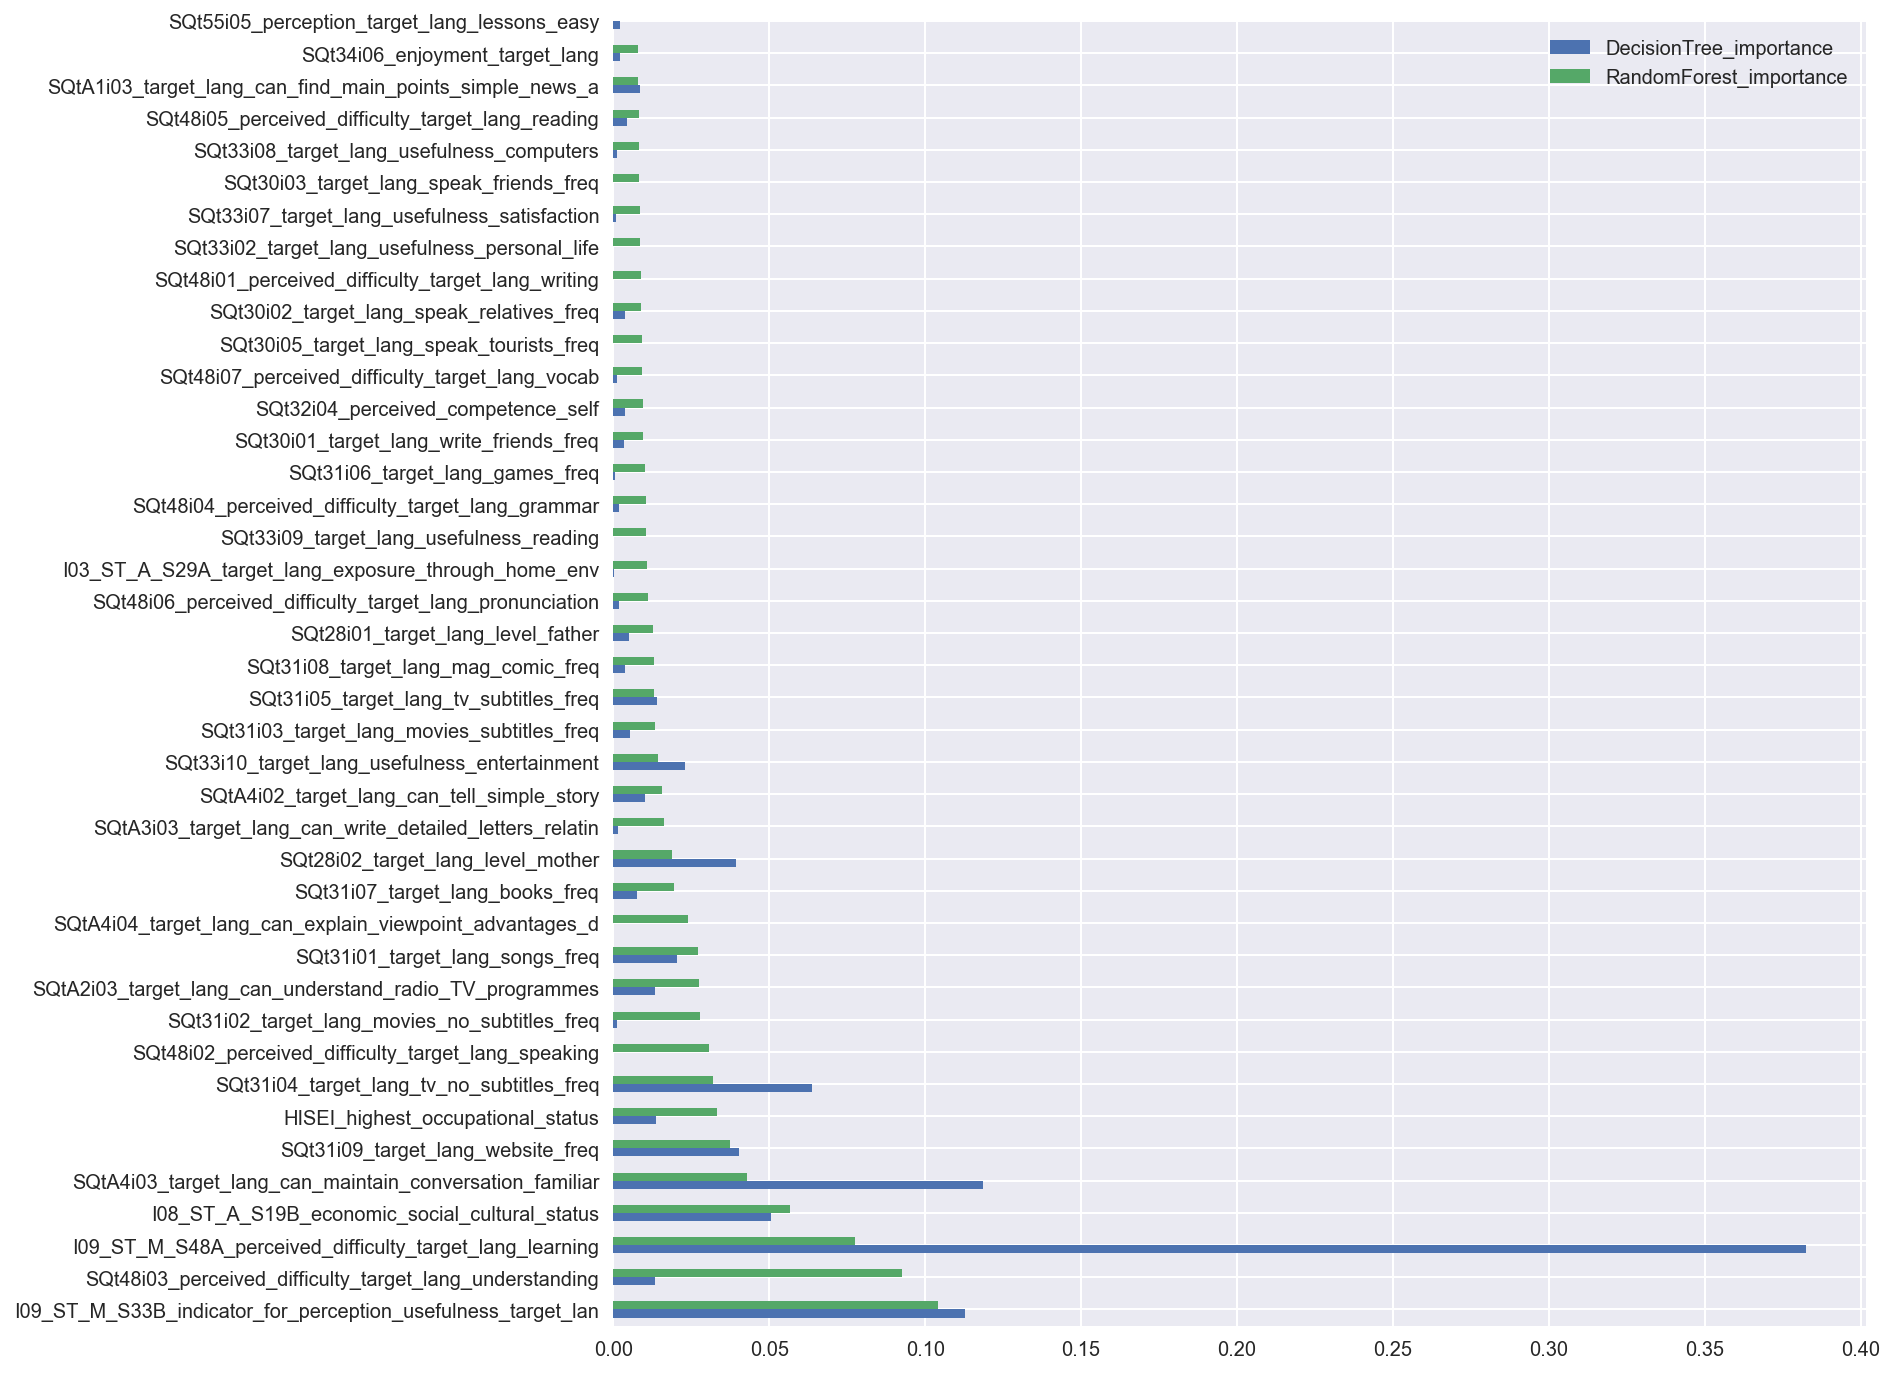

In [106]:
# plot feature importance to show difference between best Decision Tree and best Random Forest
fig, ax = plt.subplots(figsize=(10, 12))
importances.plot(kind='barh', ax=ax, fontsize=10, )
plt.ylim(ymax=40)
plt.legend(fontsize=10)
plt.show()

### Extra Trees

In [107]:
# instantiate Extra Trees Classifier model
etc = ExtraTreesClassifier(random_state=7)

# fit model
etc.fit(X_train_ss, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=7, verbose=0, warm_start=False)

In [108]:
# set hyperparameters for gridsearch on extra trees
params_etc = {'n_estimators':[200],
             'max_depth': [7, 10, 11, 20, 30],
             'max_features': [10, 20, 'log2', 'sqrt']}

In [109]:
# run gridsearch function for Extra Trees Classifier
gs_etc = grid_search_func(etc, params_etc,
                          X_train_ss, y_train, X_test_ss, y_test)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] max_depth=7, max_features=10, n_estimators=200 ..................
[CV] max_depth=7, max_features=10, n_estimators=200 ..................
[CV] max_depth=7, max_features=10, n_estimators=200 ..................
[CV] max_depth=7, max_features=10, n_estimators=200 ..................
[CV] max_depth=7, max_features=20, n_estimators=200 ..................
[CV] max_depth=7, max_features=20, n_estimators=200 ..................
[CV] ... max_depth=7, max_features=10, n_estimators=200, total=   1.2s
[CV] max_depth=7, max_features=20, n_estimators=200 ..................
[CV] ... max_depth=7, max_features=10, n_estimators=200, total=   1.2s
[CV] max_depth=7, max_features=20, n_estimators=200 ..................
[CV] ... max_depth=7, max_features=10, n_estimators=200, total=   1.2s
[CV] max_depth=7, max_features=log2, n_estimators=200 ................
[CV] ... max_depth=7, max_features=10, n_estimators=200, total=   1.3s
[CV] max_depth=7

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    9.2s


[CV]  max_depth=10, max_features=sqrt, n_estimators=200, total=   1.5s
[CV] max_depth=11, max_features=20, n_estimators=200 .................
[CV]  max_depth=10, max_features=sqrt, n_estimators=200, total=   1.5s
[CV] max_depth=11, max_features=20, n_estimators=200 .................
[CV] .. max_depth=11, max_features=10, n_estimators=200, total=   2.0s
[CV] max_depth=11, max_features=20, n_estimators=200 .................
[CV] .. max_depth=11, max_features=10, n_estimators=200, total=   2.0s
[CV] max_depth=11, max_features=20, n_estimators=200 .................
[CV] .. max_depth=11, max_features=10, n_estimators=200, total=   2.0s
[CV] max_depth=11, max_features=log2, n_estimators=200 ...............
[CV] .. max_depth=11, max_features=10, n_estimators=200, total=   2.0s
[CV] max_depth=11, max_features=log2, n_estimators=200 ...............
[CV]  max_depth=11, max_features=log2, n_estimators=200, total=   1.4s
[CV] max_depth=11, max_features=log2, n_estimators=200 ...............
[CV]  

[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:   31.8s finished


Best score:
0.8171428571428572

Best estimator:
{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 10, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': 1, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}

Test score:  0.8146666666666667

Predicted     0    1   All
Actual                    
0          1867  180  2047
1           376  577   953
All        2243  757  3000

             precision    recall  f1-score   support

          0       0.83      0.91      0.87      2047
          1       0.76      0.61      0.67       953

avg / total       0.81      0.81      0.81      3000



### Gaussian Naive Bayes

I won't run a gridsearch on this model as there are no hyperparameters to tune.

In [110]:
# instantiate Gaussian NB model
gnb = GaussianNB()

# fit model
gnb.fit(X_train_ss, y_train)

GaussianNB(priors=None)

In [113]:
# initiate model and cross validate
predictions_gnb = gnb.predict(X_test_ss)

print('Mean Cross Val Score:\t', cross_val_score(gnb, X_train_ss, y_train, cv=5).mean())
print('Score (Test Data):\t', gnb.score(X_test_ss, y_test))
print('Accuracy Score:\t', accuracy_score(y_test, predictions_gnb))

Mean Cross Val Score:	 0.777998682652389
Score (Test Data):	 0.78
Accuracy Score:	 0.78


### MLPClassifier (Neural Network)

In [114]:
mlp = MLPClassifier(solver='lbfgs', alpha=10**(-6),
                    hidden_layer_sizes=(10,10,10), 
                    activation='identity',
                    random_state=7,
                    batch_size=100)
mlp.fit(X_train_ss, y_train)
accuracy_score(y_test, mlp.predict(X_test_ss))

0.819

#### Action
My gridsearch on the MLP Classifier hung on a convergence warning so I tried a few different hyperparameters manually and settled on those in the instantiation above. As a follow up task, I need to work out how to get the gridsearch to run successfully.

In [116]:
# check number of layers
mlp.n_layers_

5

In [117]:
# check number of coefs
print([coef.shape for coef in mlp.coefs_])
print(sum([np.prod(coef.shape) for coef in mlp.coefs_]))

[(58, 10), (10, 10), (10, 10), (10, 1)]
790


## Full Dataset (53k observations)

On the basis of the results from my gridsearch on the sample of data, I will now gridsearch on the two best performing models against the whole dataset to ensure they still perform well and to identify the best hyperparameters for larger amounts of data.

### Support Vector Classifier with rbf kernel (full dataset)

In [164]:
# instantiate SVM with rbf kernel
rbf_full = svm.SVC(kernel='rbf', probability=True)

In [165]:
# create hyperparameter dictionary for gridsearch
params_rbf = {'C': np.logspace(-3,2,5),
              'gamma':np.logspace(-5,2,5)}

In [166]:
# run gridsearch function for SVM with rbf kernel
gs_rbf_full = grid_search_func(rbf_full, params_rbf,\
                          X_all_train_ss, y_all_train, X_all_test_ss, y_all_test)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total=11.7min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total=11.8min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total=11.8min
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] ............................. C=0.001, gamma=1e-05, total=11.8min
[CV] C=0.001, g

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 83.5min


[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=11.1min
[CV] C=0.01778279410038923, gamma=1.7782794100389228 .................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=11.2min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total=11.1min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=37.2min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=37.2min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=36.8min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total=36.8min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .

[CV] ................. C=5.623413251903491, gamma=100.0, total=66.7min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total=69.4min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total=71.4min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total=70.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............... C=100.0, gamma=0.03162277660168379, total=72.4min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total=71.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total=72.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 548.3min finished


Best score:
0.8214147980827503

Best estimator:
{'C': 100.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0005623413251903491, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Test score:  0.8226749791117681

Predicted      0     1    All
Actual                       
0           9845   856  10701
1           1903  2955   4858
All        11748  3811  15559

             precision    recall  f1-score   support

          0       0.84      0.92      0.88     10701
          1       0.78      0.61      0.68      4858

avg / total       0.82      0.82      0.82     15559



Note:
- Recall: the SVM model is doing significantly better at predicting low performance (0.92) than it is at predicting high performance (0.61). This means that of all the predicted high salaries, 92% of the predicted low salaries are correctly predicted. Low performance is the majority class so this could simply be a result of the model having access to twice the amount of data for that class. The overall recall of 0.82 is relatively high. Is it more important to correctly identify all students with potential to be high performers even if it means pushing those who are less likely to succeed? I feel like increasing the false positive rate would not serve in this situation.

- Precision: needs to be high in a situation where it is perhaps more important to incorrectly identify some high performers as low performers (ie. to push them even more) than to incorrectly tell students that they are already likely to be high performing and therefore maybe not push them as much. In the context of education where all students should be applying themselves, I feel that precision is more important than recall. This model is doing better at correctly predicting the high performers with fewer false negatives.

### Random Forest with full dataset

In [145]:
# initiate Random Forest model
rf_full = RandomForestClassifier(random_state=7)

# fit random forest model
rf_full.fit(X_all_train_ss, y_all_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [146]:
# set hyperparameters for gridsearch on random forest
params_rf_full = {'n_estimators':[20, 30, 40],
             'max_depth': [7, 10, 11, 20, 30],
             'max_features': [10, 20, 'log2', 'sqrt']}

In [147]:
# run gridsearch function for Random Forest
gs_rf_full = grid_search_func(rf_full, params_rf_full,\
                          X_all_train_ss, y_all_train, X_all_test_ss, y_all_test)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   1.2s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   1.2s
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   1.2s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=40 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   1.2s
[CV] max_depth=

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   10.8s


[CV] .... max_depth=7, max_features=20, n_estimators=40, total=   3.7s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .... max_depth=7, max_features=20, n_estimators=40, total=   3.7s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.9s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.9s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   1.3s
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   1.3s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   1.3s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .

[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   1.5s
[CV] max_depth=10, max_features=sqrt, n_estimators=40 ................
[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   1.5s
[CV] max_depth=10, max_features=sqrt, n_estimators=40 ................
[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   1.4s
[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   1.5s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   1.9s
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   1.9s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   1.3s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] .

[CV] ... max_depth=20, max_features=10, n_estimators=20, total=   1.7s
[CV] ... max_depth=20, max_features=10, n_estimators=20, total=   1.6s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   2.4s
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   2.4s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   2.4s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   2.4s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................


[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   54.5s


[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   3.1s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   3.1s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   2.8s
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   2.8s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   3.2s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   3.2s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   2.8s
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   2.8s
[CV] m

[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   4.0s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   4.1s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   1.1s
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] ... max_depth=30, max_features=20, n_estimators=40, total=   5.5s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] .

[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:  1.6min finished


Best score:
0.8154647126880061

Best estimator:
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 40, 'n_jobs': 1, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}

Test score:  0.8164406452856867

Predicted      0     1    All
Actual                       
0           9714   987  10701
1           1869  2989   4858
All        11583  3976  15559

             precision    recall  f1-score   support

          0       0.84      0.91      0.87     10701
          1       0.75      0.62      0.68      4858

avg / total       0.81      0.82      0.81     15559



In [148]:
# create df showing features in order of impact on the model
importances_rf = pd.DataFrame(best_rf.feature_importances_,\
                              index=X_all_train.columns,\
                              columns=['importance'])\
                              .sort_values('importance', ascending=True)
importances_rf.head(20)

importance
SQtA1i02_target_lang_can_find_info_ads_timetabl...    0.002408
SQt29i06_target_lang_internet                         0.002507
SQtA2i02_target_lang_can_understand_if_spoken_s...    0.002773
SQt26i05_lang_used_at_home_target                     0.003217
I03_ST_A_S26B_target_lang_used_home                   0.003246
SQt29i01_target_lang_exposure_penfriend               0.003274
SQtA2i01_target_lang_can_understand_qs_instruct...    0.003310
SQtA1i04_target_lang_can_read_long_complex_text...    0.003355
SQtA3i04_target_lang_can_write_detailed_review_...    0.003678
SQtA3i02_target_lang_can_write_basic_descriptio...    0.004286
SQtA2i04_target_lang_can_understand_long_compli...    0.004318
SQt29i07_target_lang_holidays                         0.004989
SQt33i06_target_lang_usefulness_contact_foreigners    0.005699
SQt33i05_target_lang_usefulness_getting_job           0.006332
SQt33i01_target_lang_usefulness_travel                0.007282
SQt30i06_target_lang_speak_internet_freq              0.007370
SQt35i06_usefulness_target_lang                       0.007501
SQt55i05_perception_target_lang_lessons_easy          0.007724
SQt34i06_enjoyment_target_lang                        0.007825
SQtA1i03_target_lang_can_find_main_points_simpl...    0.007993

In [177]:
# set path to save importances to csv
path='/Users/lizspiking/DataScience/language-competence/'

# save df to csv
importances_rf.to_csv(path + 'importances_rf.csv', sep=',', na_rep='', float_format=None,\
                 header=True, index=False, mode='w', encoding='UTF-8',\
                 compression=None, quoting=None, quotechar='"',\
                 line_terminator='\n', decimal='.')

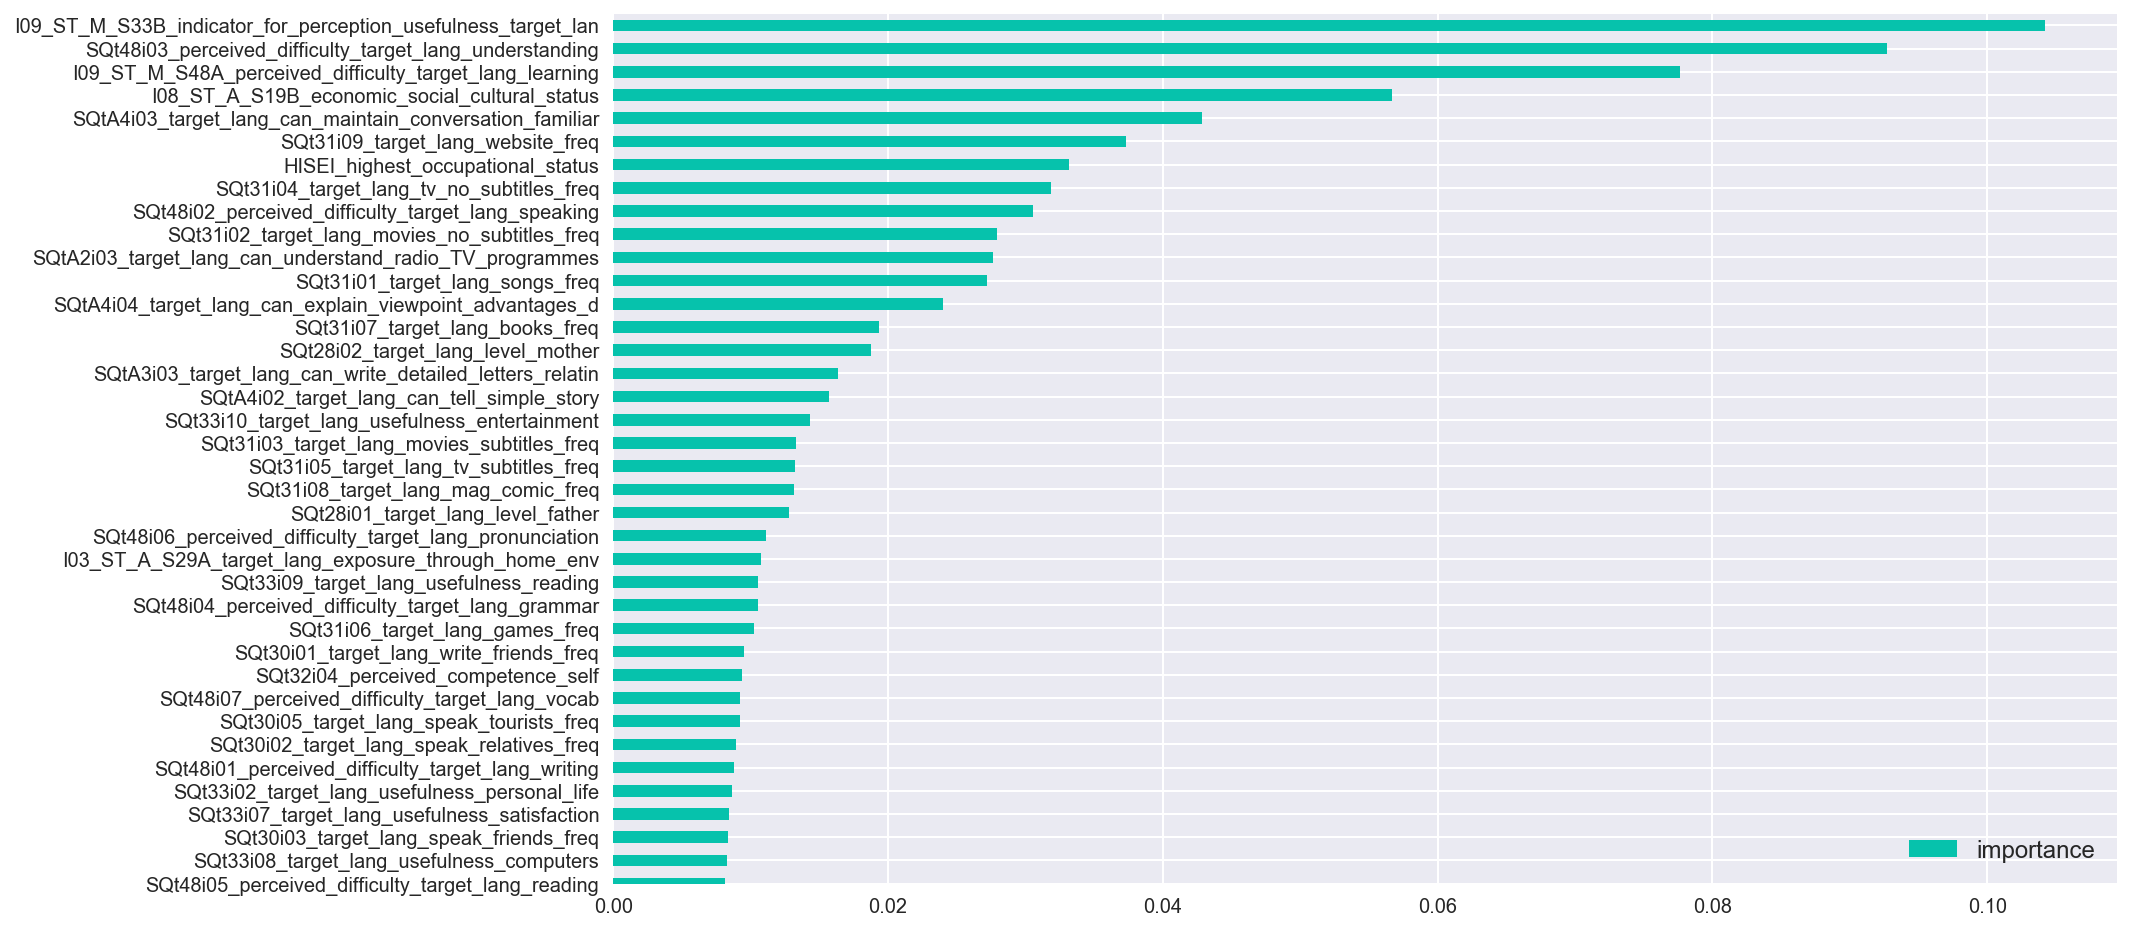

In [178]:
# plot feature importance to show difference between best Decision Tree and best Random Forest
fig, ax = plt.subplots(figsize=(12, 8))
importances_rf.plot(kind='barh', ax=ax, fontsize=10, color='xkcd:turquoise')
plt.ylim(ymin=20)
plt.legend(fontsize=12)
plt.show()
fig.savefig('/Users/lizspiking/Documents/Data Science/Capstone Project/Language/to.png')

In [152]:
gs_rf_full

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'n_estimators': [20, 30, 40], 'max_depth': [7, 10, 11, 20, 30], 'max_features': [10, 20, 'log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

Note:
- All the scores are higher for the 0 class than they are for the 1 class, which means that model is doing better at predicting low performance than it is at predicting high performance. A contributing factor to this could be the fact that there is twice as much data for the low performance class in the dataset and therefore the model has been able to make use of more data to identify differentiating factors for the 0 class. To address this I could subset the data to be more evenly balanced between the two classes or I could use bootstrapping to increase the ratio of class 1 to class 0.

Recall:
- relates to the ratio of correctly predicted positives against all the positives in y_true (true positives out of all the true positives and false negatives). The higher the recall, the fewer instances there are of true positive values having been falsely predicted as negative which means that here, there is a higher likelihood of a high performer being incorrectly identified as a low performer than there is of a low performer being incorrectly identified as a high performer.
- The overall recall of 0.82 is the same as for the SVM model. Is it more important to correctly identify all students with potential to be high performers even if it means pushing those who are less likely to succeed? I feel like increasing the false positive rate would not serve in this situation.

Precision:
- relates to the ratio of correctly predicted positives against all the positives in y_pred (true positives out of everything predicted as positive (true positives and false positives)). The higher the precision, the fewer instances there are of negative values having falsely predicted as positive.  The precision needs to be high in a situation where it is perhaps preferable to incorrectly identify some high performers as low performers (ie. to push them even more) than to incorrectly tell low performing students that they are likely to be high performing and therefore maybe not push them as much. In the context of education where applying oneself is critical, I feel that precision is more important than recall.

## Model Evaluation

### Random Forest

In [153]:
# create a confusion matrix with cross_val_predict
predictions_rf = cross_val_predict(gs_rf_full, X_all_test, y_all_test, cv=4)
confusion_rf = confusion_matrix(y_all_test, predictions_rf)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=40 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    3.1s


[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.2s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.2s
[CV] max_depth=7, max_features=sqrt, n_estimators=40 .................
[CV] .

[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   0.5s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] .

[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.8s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................


[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   16.6s


[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=40 ..................
[CV] .

[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] ... max_depth=30, max_features=20, n_estimators=40, total=   1.5s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] .

[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:   29.2s finished


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=40 ...................
[CV] max_depth=

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    3.0s


[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.2s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.2s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=sqrt, n_estimators=40 .................
[CV] .

[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   0.5s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   0.5s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] .

[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.8s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.8s
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................


[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   16.2s


[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=40 ..................
[CV] .

[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   1.2s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] ... max_depth=30, max_features=20, n_estimators=40, total=   1.6s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] .

[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:   28.8s finished


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=40 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    2.9s


[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.2s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.2s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=sqrt, n_estimators=40 .................
[CV] .

[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   0.5s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   0.5s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] .

[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................


[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   16.0s


[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=40 ..................
[CV] .

[CV] max_depth=30, max_features=20, n_estimators=40 ..................
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] ... max_depth=30, max_features=20, n_estimators=40, total=   1.6s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] .

[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:   28.7s finished


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=20 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=10, n_estimators=30 ...................
[CV] max_depth=7, max_features=10, n_estimators=40 ...................
[CV] .... max_depth=7, max_features=10, n_estimators=20, total=   0.3s
[CV] max_depth=

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    2.9s


[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.2s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.2s
[CV] max_depth=7, max_features=sqrt, n_estimators=20 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=log2, n_estimators=40, total=   0.4s
[CV] max_depth=7, max_features=sqrt, n_estimators=30 .................
[CV] .. max_depth=7, max_features=sqrt, n_estimators=20, total=   0.3s
[CV] max_depth=7, max_features=sqrt, n_estimators=40 .................
[CV] .

[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   0.5s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=30, total=   0.5s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=20 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] ... max_depth=11, max_features=10, n_estimators=20, total=   0.4s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] . max_depth=10, max_features=sqrt, n_estimators=40, total=   0.6s
[CV] max_depth=11, max_features=10, n_estimators=30 ..................
[CV] .

[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=10, n_estimators=40 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=30, total=   0.7s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................


[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   16.0s


[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=20 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.8s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.9s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=10, n_estimators=40, total=   1.0s
[CV] max_depth=20, max_features=20, n_estimators=30 ..................
[CV] ... max_depth=20, max_features=20, n_estimators=20, total=   0.9s
[CV] max_depth=20, max_features=20, n_estimators=40 ..................
[CV] .

[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   1.1s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] ... max_depth=30, max_features=20, n_estimators=30, total=   1.2s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=20 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] . max_depth=30, max_features=log2, n_estimators=20, total=   0.3s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] ... max_depth=30, max_features=20, n_estimators=40, total=   1.6s
[CV] max_depth=30, max_features=log2, n_estimators=30 ................
[CV] .

[Parallel(n_jobs=6)]: Done 240 out of 240 | elapsed:   28.6s finished


In [154]:
# save as df
confusion_matrix_rf = pd.DataFrame(confusion_rf, columns=sorted(y_all_train.unique()),\
                                   index=sorted(y_all_train.unique()))
confusion_matrix_rf

0     1
0  9706   995
1  1930  2928

In [155]:
# calculate true/false positives and true/false negatives from Random Forest
tp = np.sum((y_all_test == 1) & (predictions_rf == 1))
fp = np.sum((y_all_test == 0) & (predictions_rf == 1))
tn = np.sum((y_all_test == 0) & (predictions_rf == 0))
fn = np.sum((y_all_test == 1) & (predictions_rf == 0))

print("tp:", tp)
print("fp:", fp)
print("tn:", tn) 
print("fn:", fn)
print("Number of classification errors:", fp+fn)

tp: 2928
fp: 995
tn: 9706
fn: 1930
Number of classification errors: 2925


### SVC

In [169]:
gs_rbf_full.best_params_

{'C': 100.0, 'gamma': 0.0005623413251903491}

In [170]:
# create a confusion matrix with cross_val_predict
predictions_rbf = cross_val_predict(gs_rbf_full, X_all_test, y_all_test, cv=4)
confusion_rbf = confusion_matrix(y_all_test, predictions_rbf)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, g

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  6.9min


[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.2min
[CV] C=0.01778279410038923, gamma=1.7782794100389228 .................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.2min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.2min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.7min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.7min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.7min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.7min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .

[CV] ............. C=100.0, gamma=0.0005623413251903491, total=  52.8s
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 2.0min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 1.9min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 23.8min finished


Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.0min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.0min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.0min
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.0min
[CV] C=0.001, g

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  6.4min


[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.2min
[CV] C=0.01778279410038923, gamma=1.7782794100389228 .................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.2min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.2min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .

[CV] ............. C=100.0, gamma=0.0005623413251903491, total=  57.7s
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.7min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.7min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 2.0min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 2.0min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 23.8min finished


Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] C=0.001, g

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  6.7min


[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.1min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.1min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] ............... C=0.01778279410038923, gamma=100.0, total= 1.4min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .

[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.5min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.5min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 1.8min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 1.8min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 1.8min
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 1.8min
[CV] .

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 23.4min finished


Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=1e-05 ............................................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, gamma=0.0005623413251903491 ............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, gamma=0.03162277660168379 ..............................
[CV] ............................. C=0.001, gamma=1e-05, total= 1.1min
[CV] C=0.001, g

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  6.7min


[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.1min
[CV] C=0.01778279410038923, gamma=1.7782794100389228 .................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.1min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] . C=0.01778279410038923, gamma=0.03162277660168379, total= 1.1min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.01778279410038923, gamma=100.0 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .. C=0.01778279410038923, gamma=1.7782794100389228, total= 1.6min
[CV] C=0.31622776601683794, gamma=1e-05 ..............................
[CV] .

[CV] ............. C=100.0, gamma=0.0005623413251903491, total=  53.4s
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=1.7782794100389228 ...............................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ............... C=100.0, gamma=0.03162277660168379, total= 1.6min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 1.9min
[CV] C=100.0, gamma=100.0 ............................................
[CV] ................ C=100.0, gamma=1.7782794100389228, total= 1.9min
[CV] C=100.0, gamma=100.0 ............................................
[CV] .

[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed: 23.5min finished


In [171]:
# save as df
confusion_matrix_rbf = pd.DataFrame(confusion_rbf, columns=sorted(y_all_train.unique()),\
                                   index=sorted(y_all_train.unique()))
confusion_matrix_rbf

0     1
0  9798   903
1  1938  2920

In [172]:
# calculate true/false positives and true/false negatives from SVM
tp_svm = np.sum((y_all_test == 1) & (predictions_rbf == 1))
fp_svm = np.sum((y_all_test == 0) & (predictions_rbf == 1))
tn_svm = np.sum((y_all_test == 0) & (predictions_rbf == 0))
fn_svm = np.sum((y_all_test == 1) & (predictions_rbf == 0))

print("tp:", tp_svm)
print("fp:", fp_svm)
print("tn:", tn_svm) 
print("fn:", fn_svm)
print("Number of classification errors:", fp_svm+fn_svm)

tp: 2920
fp: 903
tn: 9798
fn: 1938
Number of classification errors: 2841


## ROC Curve

In [156]:
# create dataframe to adjust threshold
thresholds_rf = pd.DataFrame({'y_true': y_all_test,
                              'y_hat': predictions_rf,
                              'prob_1':gs_rf_full.predict_proba(X_all_test)[:,1]})

thresholds_rf['60%_threshold'] = thresholds_rf['prob_1'].map(lambda x: 1 if x>0.6 else 0)
thresholds_rf['40%_threshold'] = thresholds_rf['prob_1'].map(lambda x: 1 if x>0.4 else 0)
thresholds_rf.head(10)

prob_1  y_hat  y_true  60%_threshold  40%_threshold
14478   0.700      1       1              1              1
17620   0.550      1       1              0              1
24880   0.400      0       0              0              0
22809   0.525      0       0              0              1
9576    0.425      0       0              0              1
35509   0.525      1       1              0              1
358     0.200      0       0              0              0
25077   0.400      0       0              0              0
44120   0.775      1       1              1              1
17478   0.750      1       1              1              1

In [157]:
# create dataframe to show FPR and TPR against each corresponding threshold
fpr, tpr, threshold = roc_curve(y_all_test,thresholds_rf['prob_1'])
fpr_tpr_df = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':threshold})

In [158]:
# review df
fpr_tpr_df.head()

FPR       TPR  Threshold
0  0.000000  0.000206      0.975
1  0.000000  0.000823      0.950
2  0.000000  0.002264      0.925
3  0.000000  0.006175      0.900
4  0.000093  0.010704      0.875

In [173]:
# create dataframe to adjust threshold
thresholds_svm = pd.DataFrame({'y_true': y_all_test,
                              'y_hat': predictions_rbf,
                              'prob_1':gs_rbf_full.predict_proba(X_all_test)[:,1]})

thresholds_svm['70%_threshold'] = thresholds_svm['prob_1'].map(lambda x: 1 if x>0.7 else 0)
thresholds_svm['30%_threshold'] = thresholds_svm['prob_1'].map(lambda x: 1 if x>0.3 else 0)
thresholds_svm.head(10)

prob_1  y_hat  y_true  70%_threshold  30%_threshold
14478  1.000000e-07      1       1              0              0
17620  1.849472e-05      1       1              0              0
24880  4.014954e-07      0       0              0              0
22809  7.796116e-03      0       0              0              0
9576   2.631994e-05      0       0              0              0
35509  1.000000e-07      1       1              0              0
358    1.025749e-06      0       0              0              0
25077  5.474605e-03      0       0              0              0
44120  3.703141e-06      1       1              0              0
17478  9.225859e-07      1       1              0              0

In [174]:
# create dataframe to show FPR and TPR against each corresponding threshold
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_all_test,thresholds_svm['prob_1'])
fpr_tpr_svm = pd.DataFrame({'FPR':fpr_svm,'TPR':tpr_svm,'Threshold':threshold_svm})

In [175]:
# review df
fpr_tpr_svm.head()

FPR       TPR  Threshold
0  0.000000  0.000206   0.971785
1  0.000000  0.002264   0.849059
2  0.000280  0.002264   0.774467
3  0.000280  0.002470   0.768777
4  0.000561  0.002470   0.757995

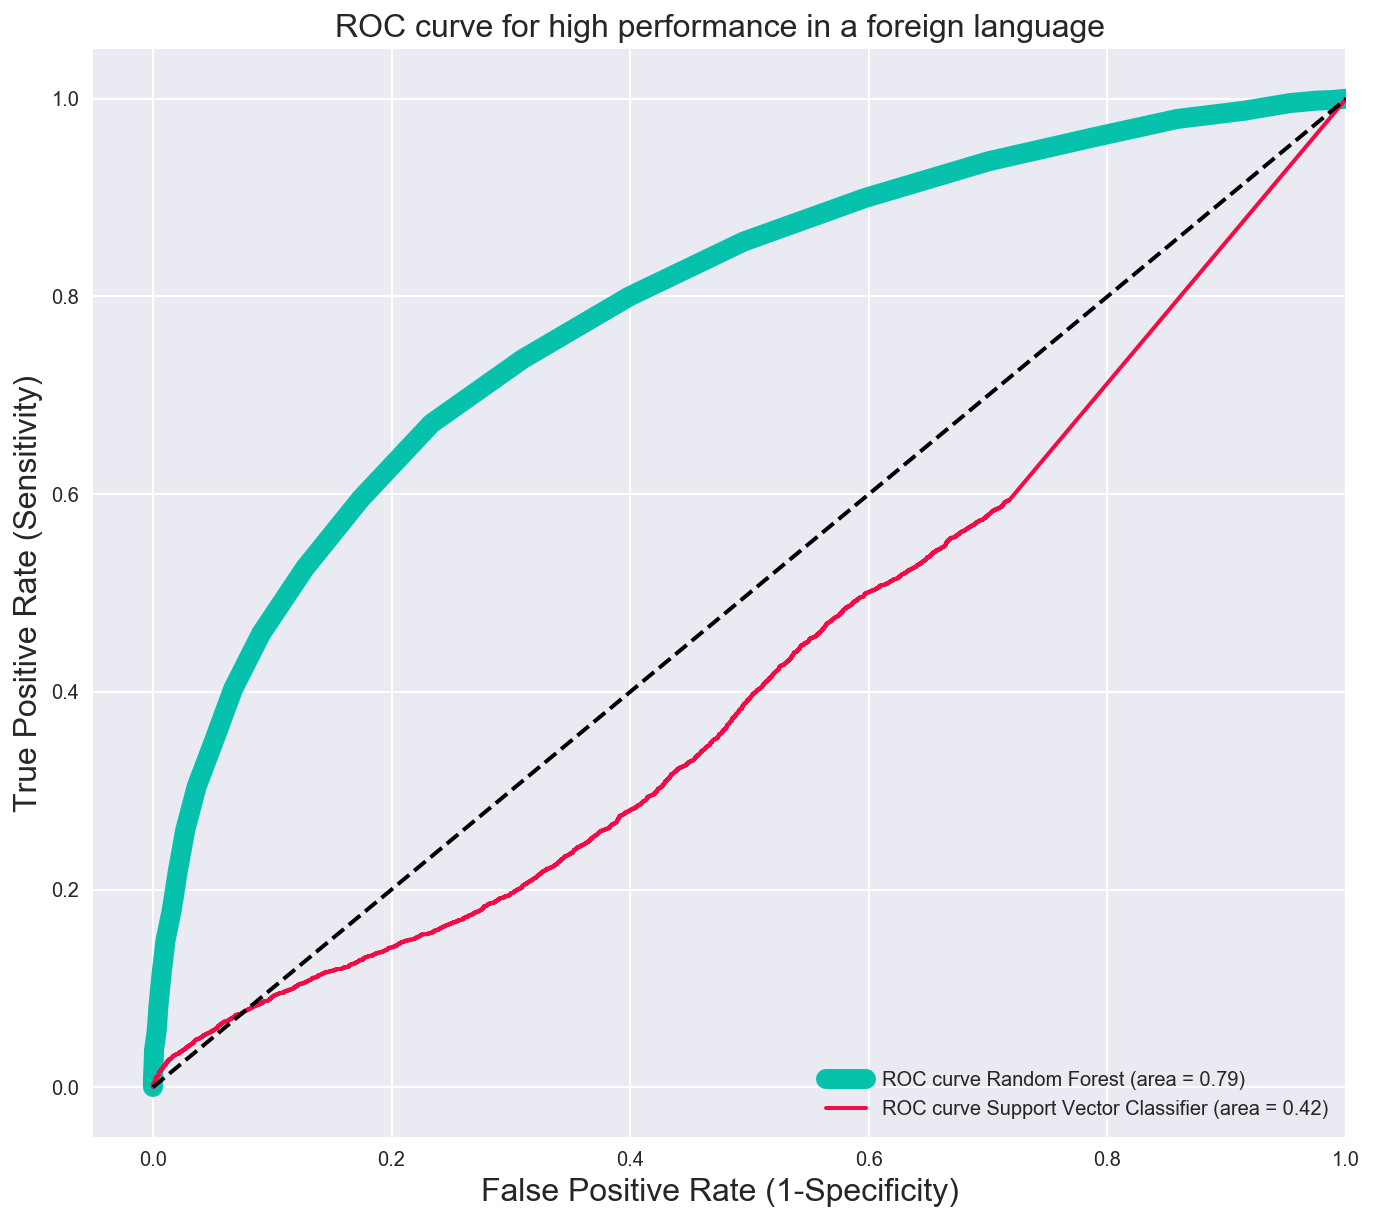

In [176]:
# For high performance, find the area under the curve
roc_auc_rf = auc(fpr, tpr)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve for class 1 (high performance)
plt.figure(figsize=[10,10])
# ROC curve for Random Forest model
_ = plt.plot(fpr, tpr, label='ROC curve Random Forest (area = %0.2f)' % roc_auc_rf, linewidth=10, color='xkcd:turquoise')
# ROC curve for SVM model
_ = plt.plot(fpr_svm, tpr_svm, label='ROC curve Support Vector Classifier (area = %0.2f)' % roc_auc_svm, linewidth=2, color='xkcd:pinkish red')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (1-Specificity)', fontsize=16)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=16)
plt.title('ROC curve for high performance in a foreign language', fontsize=16)
plt.legend(loc="lower right")
plt.show()

Note:
- The ROC curve for the random forest model is pretty smooth with the sharpest increase in true positive rate up to a false positive rate of around 0.25. After that point the gains in true positives slows and the false posiitve rate increases much faster for each small increment in the TPR. A specificity of 0.75 would be the optimum here as it would prevent too many students from the low performing class being mis-identified as being in the high performing class while still correctly identifying around 70% of the high performing students.
- The ROC curve for the SVM model shows that the false positive rate increases much faster than the true positive rate, particularly at the lower thresholds. The random forest has a much higher AUC and so I would expect it to perform better than the SVM at all thresholds.

## Simple Pipeline

As the results are so similar between the two models and a Random Forest model is easier to explain to stakeholders, I will put that into the pipeline.

In [179]:
# instantiate pipeline
rf_pipeline = Pipeline([('ss',StandardScaler()),
                        #('pca',PCA()),
                        ('rfr',RandomForestClassifier())])

# set gridsearch hyperparameters
rfp_params = {
            #'pca__n_components': (17,20,25,None),
            'rfr__n_estimators': [20, 30, 40],        
            'rfr__max_depth': [7, 10, 11, 20, 30],
            'rfr__max_features': [10, 20, 'log2', 'sqrt']
            }

In [180]:
# instantiate gridsearch on pipeline
gs_pl = GridSearchCV(rf_pipeline, rfp_params, n_jobs=6, verbose=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in rf_pipeline.steps])
print("parameters:")
print(rfp_params)
gs_pl.fit(X_train, y_train) # this is running on the subset of 10000 observations for expediency
print()

print("Best score: %0.3f" % gs_pl.best_score_)
print("Best parameters set:")
best_parameters = gs_pl.best_estimator_.get_params()
for param_name in sorted(rfp_params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['ss', 'rfr']
parameters:
{'rfr__n_estimators': [20, 30, 40], 'rfr__max_depth': [7, 10, 11, 20, 30], 'rfr__max_features': [10, 20, 'log2', 'sqrt']}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=20 ....
[CV] rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=20 ....
[CV] rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=20 ....
[CV] rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=30 ....
[CV] rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=30 ....
[CV] rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=30 ....
[CV]  rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=20, total=   0.2s
[CV]  rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=20, total=   0.2s
[CV] rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=40 ....
[CV]  rfr__max_depth=7, rfr__max_features=10, rfr__n_estimators=20, total=   0.2s
[CV] rfr__m

[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    1.5s


[CV]  rfr__max_depth=7, rfr__max_features=sqrt, rfr__n_estimators=30, total=   0.2s
[CV] rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=20 ...
[CV]  rfr__max_depth=7, rfr__max_features=sqrt, rfr__n_estimators=40, total=   0.2s
[CV] rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=7, rfr__max_features=sqrt, rfr__n_estimators=40, total=   0.3s
[CV] rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=7, rfr__max_features=sqrt, rfr__n_estimators=40, total=   0.3s
[CV] rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=20, total=   0.2s
[CV]  rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=20, total=   0.2s
[CV] rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=40 ...
[CV] rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=40 ...
[CV]  rfr__max_depth=10, rfr__max_features=10, rfr__n_estimators=20, tot

[CV]  rfr__max_depth=11, rfr__max_features=20, rfr__n_estimators=30, total=   0.6s
[CV] rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=20 .
[CV]  rfr__max_depth=11, rfr__max_features=20, rfr__n_estimators=30, total=   0.5s
[CV] rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=20 .
[CV]  rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=20, total=   0.2s
[CV]  rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=20, total=   0.2s
[CV] rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=30 .
[CV] rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=30 .
[CV]  rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=20, total=   0.2s
[CV] rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=30 .
[CV]  rfr__max_depth=11, rfr__max_features=20, rfr__n_estimators=40, total=   0.7s
[CV] rfr__max_depth=11, rfr__max_features=log2, rfr__n_estimators=40 .
[CV]  rfr__max_depth=11, rfr__max_features=20, rfr__n_estimators=40, t

[CV]  rfr__max_depth=20, rfr__max_features=sqrt, rfr__n_estimators=30, total=   0.3s
[CV] rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators=20 ...
[CV]  rfr__max_depth=20, rfr__max_features=sqrt, rfr__n_estimators=30, total=   0.3s
[CV] rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators=20 ...
[CV]  rfr__max_depth=20, rfr__max_features=sqrt, rfr__n_estimators=30, total=   0.3s
[CV] rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators=20 ...
[CV]  rfr__max_depth=20, rfr__max_features=sqrt, rfr__n_estimators=40, total=   0.4s
[CV] rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=20, rfr__max_features=sqrt, rfr__n_estimators=40, total=   0.4s
[CV] rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=20, rfr__max_features=sqrt, rfr__n_estimators=40, total=   0.5s
[CV] rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators

[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    9.5s


[CV] rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators=40, total=   0.6s
[CV] rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=30, rfr__max_features=10, rfr__n_estimators=40, total=   0.5s
[CV] rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=30 ...
[CV]  rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=20, total=   0.5s
[CV] rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=40 ...
[CV]  rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=20, total=   0.4s
[CV]  rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=20, total=   0.5s
[CV] rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=40 ...
[CV] rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=40 ...
[CV]  rfr__max_depth=30, rfr__max_features=20, rfr__n_estimators=30, total=   0.7s
[CV] rfr__max_depth=30, rfr__max_features=log2, rfr__n_estimators=20 .
[CV] 

[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:   12.0s finished



Best score: 0.813
Best parameters set:
	rfr__max_depth: 20
	rfr__max_features: 'sqrt'
	rfr__n_estimators: 40


In [181]:
# review best mean cross-validated score on training data
print('Mean cross val score against training set:\t')
print(gs_pl.best_score_.round(3))

# score model against test set
print('Best score against test set:\t')
print(gs_pl.score(X_test, y_test))

# make predictions against the test set
print('Predictions for test set:\t')
print(gs_pl.predict(X_test))

Mean cross val score against training set:	
0.813
Best score against test set:	
0.8123333333333334
Predictions for test set:	
[0 1 0 ... 1 1 0]


## Next Steps

There are a number of things I want to do on this project which I have run out of time for but which I will look at subsequently:

- follow up on the gridsearches that were hanging and tune them sufficiently to allow them to run successfully
- multiclass model (SVM?)
- make a final decision about adding some more features to the train/test data set and run models against that data if so
- run models against my the PCA (and add to pipeline if beneficial)
- use best performing models to predict discipline-specific results to see how they perform and whether there are features that are specifically contribute to performance in each discipline, rather than simply overall
- write a transformer to streamline the data cleaning/standardisation process
- update the pipeline to make the transformer and final model production ready

## PARKING LOT

This section contains code snippets for things I have tried/want to include in my next steps.

In [ ]:
# subset df to students tested on listening and writing
#list_writ = lang.loc[(lang['PL_LIST'] != 'Not Tested') & (lang['PL_WRIT'] != 'Not Tested')].copy()

In [ ]:
# subset df to students tested on reading and writing
#read_writ = lang.loc[(lang['PL_READ'] != 'Not Tested') & (lang['PL_WRIT'] != 'Not Tested')].copy()

In [ ]:
# subset df to students tested on listening and reading
#list_read = lang.loc[(lang['PL_LIST'] != 'Not Tested') & (lang['PL_READ'] != 'Not Tested')].copy()

### Reading Subset

In [22]:
# create reading train/test split
X_read_train, X_read_test, y_read_train, y_read_test = train_test_split(X_read, y_read,\
                                                                        test_size=0.3,\
                                                                        shuffle=True, random_state=7)

In [23]:
# instantiate StandardScaler and apply to predictors
ss = StandardScaler()
X_read_train_ss = ss.fit_transform(X_read_train)
X_read_test_ss = ss.transform(X_read_test)

### Writing Subset

In [24]:
# create writing train/test split
X_writ_train, X_writ_test, y_writ_train, y_writ_test = train_test_split(X_writ, y_writ,\
                                                                        test_size=0.3,\
                                                                        shuffle=True, random_state=7)

In [25]:
# instantiate StandardScaler and apply to predictors
ss = StandardScaler()
X_writ_train_ss = ss.fit_transform(X_writ_train)
X_writ_test_ss = ss.transform(X_writ_test)

### MLP Classifier Gridsearch

In [277]:
# set hyperparameters for gridsearch on MLP Classifier
#params_mlp = {'solver':['adam', 'lbfgs'],
#              'activation':['relu', 'identity']}

In [278]:
# run gridsearch for MLP Classifier
#gs_mlp = grid_search_func(mlp, params_mlp,\
#                          X_train_ss, y_train, X_test_ss, y_test)

Possible alternative to gridsearching? For loop:
    - for C in [values]:
        for l in [l1, l2]:
            ... add scores to list 